# PROJECT : User Engagement Analysis for Restaurant Success

# Problem Statement

In a Competative Market Like The Restaurant Industry, Understanding the Factors that influence Business success is Crucial for Stakeholders. Utlilsing the YELP Dataset, this Project aims to Investigate the Relationship Between User Engagement (review,tips and check-ins) and Business Success metrics (review count,ratings) for restaurants.

# Research Objective

**1.Quantitfy the correlation between user engagement (reviews,tips,check-ins) and review count/average star rating:** This will help us determine if the restaurants with higher engagement experiance a coresponding increase in review and ratings.    


**2. Analyze the impact of sentiment on review count and average star rating:** We will investigate if positive sentiment in review and tips translates to higher star ratings and potentially influences the total number of reviews left.     


**3.Time Trends in user Engagement:** we will explore if consistent engagement over time is a stronger indicator of long-term success comparedto sporadic bursts of activity.

# Hypothesis Testing

- Higher levels of user engagement (more reviews,tips, and check-ins) correlate with higher review counts and ratings for restaurants.    

- positive sentiments expressed in reviews and tips contributes to higher overall ratings and review counts for restaurants.   

- consistant engagement over time is positively associated with sustained success for restaurants.

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import json
from sqlalchemy import create_engine

import warnings
warnings.filterwarnings("ignore")

# Database Connection

In [2]:
pip install pymysql

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [3]:
username = "root"
password = "Akshay2706#MYSQL"
host = "localhost"
port = 3306
database = "yelp"

connection = f'mysql+pymysql://{username}:{password}@{host}:{port}/{database}' 
        
engine = create_engine(connection)
print("MySQL connection established successfully")

MySQL connection established successfully


# Loading Tables to Database

## Loading 1st Table: Business

In [11]:
import os


# 1. File path
folder_path = r'C:\Users\pc\Desktop\yelp dataset\json files'
file_name = "yelp_academic_dataset_business.json"
file_path = os.path.join(folder_path, file_name)



# 2. Load and insert in chunks
chunk = []
chunk_size = 10000
row_count = 0

with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        chunk.append(json.loads(line))
        row_count += 1

        if row_count % chunk_size == 0:
            df = pd.json_normalize(chunk)
            df.columns = df.columns.str.replace(r'[^\w]', '_', regex=True)
            df = df.loc[:, df.applymap(lambda x: not isinstance(x, (dict, list))).all()]
            df = df.astype(str)

            try:
                df.to_sql('business', con=engine, if_exists='append', index=False)
                print(f"{row_count} rows inserted...")
            except Exception as e:
                print(f"❌ Error inserting at row {row_count}: {e}")
                df.head().to_csv("debug_failed_chunk.csv", index=False)
                break

            chunk = []

# ✅ Final leftover chunk
if chunk:
    df = pd.json_normalize(chunk)
    df.columns = df.columns.str.replace(r'[^\w]', '_', regex=True)
    df = df.loc[:, df.applymap(lambda x: not isinstance(x, (dict, list))).all()]
    df = df.astype(str)

    try:
        df.to_sql('business', con=engine, if_exists='append', index=False)
        print(f"Final {len(chunk)} rows inserted...")
    except Exception as e:
        print(f"❌ Error inserting final chunk: {e}")
        df.head().to_csv("debug_failed_chunk.csv", index=False)

print("✅ All business records loaded (or partially if error) into MySQL!")


10000 rows inserted...
20000 rows inserted...
30000 rows inserted...
40000 rows inserted...
50000 rows inserted...
60000 rows inserted...
70000 rows inserted...
80000 rows inserted...
90000 rows inserted...
100000 rows inserted...
110000 rows inserted...
120000 rows inserted...
130000 rows inserted...
140000 rows inserted...
150000 rows inserted...
Final 346 rows inserted...
✅ All business records loaded (or partially if error) into MySQL!


In [12]:

# Sample: Fetch first 5 business records
query = "SELECT * FROM business LIMIT 5;"
df_sample = pd.read_sql(query, con=engine)
df_sample


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.4266787,-119.7111968,5.0,7,0,"Doctors, Traditional Chinese Medicine, Naturop..."
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,"Shipping Centers, Local Services, Notaries, Ma..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"Department Stores, Shopping, Fashion, Home & G..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.9555052,-75.1555641,4.0,80,1,"Restaurants, Food, Bubble Tea, Coffee & Tea, B..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.3381827,-75.4716585,4.5,13,1,"Brewpubs, Breweries, Food"


## Loading 2nd Table : Checkin

In [154]:
# Load and insert checkin file (with date column fix)
file_name = "yelp_academic_dataset_checkin.json"
file_path = os.path.join(folder_path, file_name)

chunk = []
chunk_size = 10000
row_count = 0

with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        chunk.append(json.loads(line))
        row_count += 1

        if row_count % chunk_size == 0:
            df = pd.json_normalize(chunk)
            
            # Clean column names
            df.columns = df.columns.str.replace(r'[^\w]', '_', regex=True)
            df = df.loc[:, df.applymap(lambda x: not isinstance(x, (dict, list))).all()]
            df = df.astype(str)

            # Handle 'date' column by truncating or converting it
            if 'date' in df.columns:
                # Truncate date to 10 characters (e.g., 'YYYY-MM-DD')
                df['date'] = df['date'].str.slice(0, 10)

            try:
                df.to_sql('checkin', con=engine, if_exists='append', index=False)
                print(f"{row_count} rows inserted...")
            except Exception as e:
                print(f"❌ Error inserting at row {row_count}: {e}")
                df.head().to_csv("debug_failed_checkin.csv", index=False)
                break
            chunk = []

# Final chunk
if chunk:
    df = pd.json_normalize(chunk)
    df.columns = df.columns.str.replace(r'[^\w]', '_', regex=True)
    df = df.loc[:, df.applymap(lambda x: not isinstance(x, (dict, list))).all()]
    df = df.astype(str)

    # Handle 'date' column again for the final chunk
    if 'date' in df.columns:
        df['date'] = df['date'].str.slice(0, 10)

    try:
        df.to_sql('checkin', con=engine, if_exists='append', index=False)
        print(f"Final {len(chunk)} rows inserted...")
    except Exception as e:
        print(f"❌ Error inserting final chunk: {e}")
        df.head().to_csv("debug_failed_checkin.csv", index=False)

print("✅ All checkin records loaded successfully into MySQL!")


10000 rows inserted...
20000 rows inserted...
30000 rows inserted...
40000 rows inserted...
50000 rows inserted...
60000 rows inserted...
70000 rows inserted...
80000 rows inserted...
90000 rows inserted...
100000 rows inserted...
110000 rows inserted...
120000 rows inserted...
130000 rows inserted...
Final 1930 rows inserted...
✅ All checkin records loaded successfully into MySQL!


### Since, We are Not Getting Exact Data From The JSON File. 


### Therefore, We are Loading This Table From Csv File To MYSQL.

In [8]:
# Step 1: File path
csv_file_path = r'C:\Users\pc\Desktop\yelp dataset\yelp_academic_dataset_checkin.csv'

# Step 2: Load CSV into DataFrame
df_checkin = pd.read_csv(csv_file_path)

# step 3: Preview data
print(df_checkin.head())


   Unnamed: 0             business_id  \
0           0  ---kPU91CF4Lq2-WlRu9Lw   
1           1  --0iUa4sNDFiZFrAdIWhZQ   
2           2  --30_8IhuyMHbSOcNWd6DQ   
3           3  --7PUidqRWpRSpXebiyxTg   
4           4  --7jw19RH9JKXgFohspgQw   

                                                date  
0  2020-03-13 21:10:56, 2020-06-02 22:18:06, 2020...  
1  2010-09-13 21:43:09, 2011-05-04 23:08:15, 2011...  
2           2013-06-14 23:29:17, 2014-08-13 23:20:22  
3  2011-02-15 17:12:00, 2011-07-28 02:46:10, 2012...  
4  2014-04-21 20:42:11, 2014-04-28 21:04:46, 2014...  


In [14]:
from sqlalchemy.dialects.mysql import LONGTEXT

# Set 'date' column to LONGTEXT
dtype_mapping = {
    'date': LONGTEXT()
}

# step 4: Upload DataFrame to MySQL with LONGTEXT for the 'date' column
df_checkin.to_sql(name='checkin', con=engine, if_exists='replace', index=False, dtype=dtype_mapping)

print("✅ checkin.csv loaded into MySQL with 'date' column as LONGTEXT.")


✅ checkin.csv loaded into MySQL with 'date' column as LONGTEXT.


In [15]:
# Sample: Fetch first 5 checkin records
query = "SELECT * FROM checkin LIMIT 5;"
df_sample = pd.read_sql(query, con=engine)
df_sample

,Unnamed: 0,business_id,date
0,0,---kPU91CF4Lq2-WlRu9Lw,"2020-03-13 21:10:56, 2020-06-02 22:18:06, 2020..."
1,1,--0iUa4sNDFiZFrAdIWhZQ,"2010-09-13 21:43:09, 2011-05-04 23:08:15, 2011..."
2,2,--30_8IhuyMHbSOcNWd6DQ,"2013-06-14 23:29:17, 2014-08-13 23:20:22"
3,3,--7PUidqRWpRSpXebiyxTg,"2011-02-15 17:12:00, 2011-07-28 02:46:10, 2012..."
4,4,--7jw19RH9JKXgFohspgQw,"2014-04-21 20:42:11, 2014-04-28 21:04:46, 2014..."


## Loading 3rd Table : Review

In [16]:
# Load and insert review file
file_name = "yelp_academic_dataset_review.json"
file_path = os.path.join(folder_path, file_name)

chunk = []
chunk_size = 10000
row_count = 0

with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        chunk.append(json.loads(line))
        row_count += 1

        if row_count % chunk_size == 0:
            df = pd.json_normalize(chunk)
            
            # Clean column names
            df.columns = df.columns.str.replace(r'[^\w]', '_', regex=True)
            df = df.loc[:, df.applymap(lambda x: not isinstance(x, (dict, list))).all()]
            df = df.astype(str)

            try:
                df.to_sql('review', con=engine, if_exists='append', index=False)
                print(f"{row_count} rows inserted...")
            except Exception as e:
                print(f"❌ Error inserting at row {row_count}: {e}")
                df.head().to_csv("debug_failed_review.csv", index=False)
                break
            chunk = []

# Final chunk
if chunk:
    df = pd.json_normalize(chunk)
    df.columns = df.columns.str.replace(r'[^\w]', '_', regex=True)
    df = df.loc[:, df.applymap(lambda x: not isinstance(x, (dict, list))).all()]
    df = df.astype(str)

    try:
        df.to_sql('review', con=engine, if_exists='append', index=False)
        print(f"Final {len(chunk)} rows inserted...")
    except Exception as e:
        print(f"❌ Error inserting final chunk: {e}")
        df.head().to_csv("debug_failed_review.csv", index=False)

print("✅ All review records loaded successfully into MySQL!")


10000 rows inserted...
20000 rows inserted...
30000 rows inserted...
40000 rows inserted...
50000 rows inserted...
60000 rows inserted...
70000 rows inserted...
80000 rows inserted...
90000 rows inserted...
100000 rows inserted...
110000 rows inserted...
120000 rows inserted...
130000 rows inserted...
140000 rows inserted...
150000 rows inserted...
160000 rows inserted...
170000 rows inserted...
180000 rows inserted...
190000 rows inserted...
200000 rows inserted...
210000 rows inserted...
220000 rows inserted...
230000 rows inserted...
240000 rows inserted...
250000 rows inserted...
260000 rows inserted...
270000 rows inserted...
280000 rows inserted...
290000 rows inserted...
300000 rows inserted...
310000 rows inserted...
320000 rows inserted...
330000 rows inserted...
340000 rows inserted...
350000 rows inserted...
360000 rows inserted...
370000 rows inserted...
380000 rows inserted...
390000 rows inserted...
400000 rows inserted...
410000 rows inserted...
420000 rows inserted...
4

3340000 rows inserted...
3350000 rows inserted...
3360000 rows inserted...
3370000 rows inserted...
3380000 rows inserted...
3390000 rows inserted...
3400000 rows inserted...
3410000 rows inserted...
3420000 rows inserted...
3430000 rows inserted...
3440000 rows inserted...
3450000 rows inserted...
3460000 rows inserted...
3470000 rows inserted...
3480000 rows inserted...
3490000 rows inserted...
3500000 rows inserted...
3510000 rows inserted...
3520000 rows inserted...
3530000 rows inserted...
3540000 rows inserted...
3550000 rows inserted...
3560000 rows inserted...
3570000 rows inserted...
3580000 rows inserted...
3590000 rows inserted...
3600000 rows inserted...
3610000 rows inserted...
3620000 rows inserted...
3630000 rows inserted...
3640000 rows inserted...
3650000 rows inserted...
3660000 rows inserted...
3670000 rows inserted...
3680000 rows inserted...
3690000 rows inserted...
3700000 rows inserted...
3710000 rows inserted...
3720000 rows inserted...
3730000 rows inserted...


6620000 rows inserted...
6630000 rows inserted...
6640000 rows inserted...
6650000 rows inserted...
6660000 rows inserted...
6670000 rows inserted...
6680000 rows inserted...
6690000 rows inserted...
6700000 rows inserted...
6710000 rows inserted...
6720000 rows inserted...
6730000 rows inserted...
6740000 rows inserted...
6750000 rows inserted...
6760000 rows inserted...
6770000 rows inserted...
6780000 rows inserted...
6790000 rows inserted...
6800000 rows inserted...
6810000 rows inserted...
6820000 rows inserted...
6830000 rows inserted...
6840000 rows inserted...
6850000 rows inserted...
6860000 rows inserted...
6870000 rows inserted...
6880000 rows inserted...
6890000 rows inserted...
6900000 rows inserted...
6910000 rows inserted...
6920000 rows inserted...
6930000 rows inserted...
6940000 rows inserted...
6950000 rows inserted...
6960000 rows inserted...
6970000 rows inserted...
6980000 rows inserted...
6990000 rows inserted...
Final 280 rows inserted...
✅ All review records lo

In [23]:
# Sample: Fetch first 5 review records
query = "SELECT * FROM review LIMIT 5;"
df_sample = pd.read_sql(query, con=engine)
df_sample

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


## Loading 4th Table : Tip

In [17]:
# Load and insert tip file
file_name = "yelp_academic_dataset_tip.json"
file_path = os.path.join(folder_path, file_name)

chunk = []
chunk_size = 10000
row_count = 0

with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        chunk.append(json.loads(line))
        row_count += 1

        if row_count % chunk_size == 0:
            df = pd.json_normalize(chunk)
            
            # Clean column names
            df.columns = df.columns.str.replace(r'[^\w]', '_', regex=True)
            df = df.loc[:, df.applymap(lambda x: not isinstance(x, (dict, list))).all()]
            df = df.astype(str)

            try:
                df.to_sql('tip', con=engine, if_exists='append', index=False)
                print(f"{row_count} rows inserted...")
            except Exception as e:
                print(f"❌ Error inserting at row {row_count}: {e}")
                df.head().to_csv("debug_failed_tip.csv", index=False)
                break
            chunk = []

# Final chunk
if chunk:
    df = pd.json_normalize(chunk)
    df.columns = df.columns.str.replace(r'[^\w]', '_', regex=True)
    df = df.loc[:, df.applymap(lambda x: not isinstance(x, (dict, list))).all()]
    df = df.astype(str)

    try:
        df.to_sql('tip', con=engine, if_exists='append', index=False)
        print(f"Final {len(chunk)} rows inserted...")
    except Exception as e:
        print(f"❌ Error inserting final chunk: {e}")
        df.head().to_csv("debug_failed_tip.csv", index=False)

print("✅ All tip records loaded successfully into MySQL!")


10000 rows inserted...
20000 rows inserted...
30000 rows inserted...
40000 rows inserted...
50000 rows inserted...
60000 rows inserted...
70000 rows inserted...
80000 rows inserted...
90000 rows inserted...
100000 rows inserted...
110000 rows inserted...
120000 rows inserted...
130000 rows inserted...
140000 rows inserted...
150000 rows inserted...
160000 rows inserted...
170000 rows inserted...
180000 rows inserted...
190000 rows inserted...
200000 rows inserted...
210000 rows inserted...
220000 rows inserted...
230000 rows inserted...
240000 rows inserted...
250000 rows inserted...
260000 rows inserted...
270000 rows inserted...
280000 rows inserted...
290000 rows inserted...
300000 rows inserted...
310000 rows inserted...
320000 rows inserted...
330000 rows inserted...
340000 rows inserted...
350000 rows inserted...
360000 rows inserted...
370000 rows inserted...
380000 rows inserted...
390000 rows inserted...
400000 rows inserted...
410000 rows inserted...
420000 rows inserted...
4

In [24]:
# Sample: Fetch first 5 tip records
query = "SELECT * FROM tip LIMIT 5;"
df_sample = pd.read_sql(query, con=engine)
df_sample

,user_id,business_id,text,date,compliment_count
0,AGNUgVwnZUey3gcPCJ76iw,3uLgwr0qeCNMjKenHJwPGQ,Avengers time with the ladies.,2012-05-18 02:17:21,0
1,NBN4MgHP9D3cw--SnauTkA,QoezRbYQncpRqyrLH6Iqjg,They have lots of good deserts and tasty cuban...,2013-02-05 18:35:10,0
2,-copOvldyKh1qr-vzkDEvw,MYoRNLb5chwjQe3c_k37Gg,It's open even when you think it isn't,2013-08-18 00:56:08,0
3,FjMQVZjSqY8syIO-53KFKw,hV-bABTK-glh5wj31ps_Jw,Very decent fried chicken,2017-06-27 23:05:38,0
4,ld0AperBXk1h6UbqmM80zw,_uN0OudeJ3Zl_tf6nxg5ww,Appetizers.. platter special for lunch,2012-10-06 19:43:09,0


## Loading 5th Table : User

In [19]:


# Load and insert user file
file_name = "yelp_academic_dataset_user.json"
file_path = os.path.join(folder_path, file_name)

chunk = []
chunk_size = 10000
row_count = 0

with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        chunk.append(json.loads(line))
        row_count += 1

        if row_count % chunk_size == 0:
            df = pd.json_normalize(chunk)

            # Clean column names
            df.columns = df.columns.str.replace(r'[^\w]', '_', regex=True)
            df = df.loc[:, df.applymap(lambda x: not isinstance(x, (dict, list))).all()]
            df = df.drop(columns=['friends'], errors='ignore')  # Drop 'friends' column if present
            df = df.astype(str)

            try:
                df.to_sql('user', con=engine, if_exists='append', index=False)
                print(f"{row_count} rows inserted...")
            except Exception as e:
                print(f"❌ Error inserting at row {row_count}: {e}")
                df.head().to_csv("debug_failed_user.csv", index=False)
                break
            chunk = []

# Final chunk
if chunk:
    df = pd.json_normalize(chunk)
    df.columns = df.columns.str.replace(r'[^\w]', '_', regex=True)
    df = df.loc[:, df.applymap(lambda x: not isinstance(x, (dict, list))).all()]
    df = df.drop(columns=['friends'], errors='ignore')  # Drop 'friends' column if present
    df = df.astype(str)

    try:
        df.to_sql('user', con=engine, if_exists='append', index=False)
        print(f"Final {len(chunk)} rows inserted...")
    except Exception as e:
        print(f"❌ Error inserting final chunk: {e}")
        df.head().to_csv("debug_failed_user.csv", index=False)

print("✅ All user records loaded successfully into MySQL!")


10000 rows inserted...
20000 rows inserted...
30000 rows inserted...
40000 rows inserted...
50000 rows inserted...
60000 rows inserted...
70000 rows inserted...
80000 rows inserted...
90000 rows inserted...
100000 rows inserted...
110000 rows inserted...
120000 rows inserted...
130000 rows inserted...
140000 rows inserted...
150000 rows inserted...
160000 rows inserted...
170000 rows inserted...
180000 rows inserted...
190000 rows inserted...
200000 rows inserted...
210000 rows inserted...
220000 rows inserted...
230000 rows inserted...
240000 rows inserted...
250000 rows inserted...
260000 rows inserted...
270000 rows inserted...
280000 rows inserted...
290000 rows inserted...
300000 rows inserted...
310000 rows inserted...
320000 rows inserted...
330000 rows inserted...
340000 rows inserted...
350000 rows inserted...
360000 rows inserted...
370000 rows inserted...
380000 rows inserted...
390000 rows inserted...
400000 rows inserted...
410000 rows inserted...
420000 rows inserted...
4

In [25]:
# Sample: Fetch first 5 user records
query = "SELECT * FROM user LIMIT 5;"
df_sample = pd.read_sql(query, con=engine)
df_sample

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,fans,average_stars,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,qVc8ODYU5SZjKXVBgXdI7w,Walker,585,2007-01-25 16:47:26,7217,1259,5994,2007,267,3.91,...,65,55,56,18,232,844,467,467,239,180
1,j14WgRoU_-2ZE1aw1dXrJg,Daniel,4333,2009-01-25 04:35:42,43091,13066,27281,"2009,2010,2011,2012,2013,2014,2015,2016,2017,2...",3138,3.74,...,264,184,157,251,1847,7054,3131,3131,1521,1946
2,2WnXYQFK0hXEoTxPtV2zvg,Steph,665,2008-07-25 10:41:00,2086,1010,1003,"2009,2010,2011,2012,2013",52,3.32,...,13,10,17,3,66,96,119,119,35,18
3,SZDeASXq7o05mMNLshsdIA,Gwen,224,2005-11-29 04:38:33,512,330,299,"2009,2010,2011",28,4.27,...,4,1,6,2,12,16,26,26,10,9
4,hA5lMy-EnncsH4JoR-hFGQ,Karen,79,2007-01-05 19:40:59,29,15,7,,1,3.54,...,1,0,0,0,1,1,0,0,0,0


### SQL Query To View all The Table Names Present in Dataset

In [22]:
query = "SHOW TABLES;"

df = pd.read_sql_query(query,con=engine)
df

,Tables_in_yelp
0,business
1,checkin
2,review
3,tip
4,user


# 1. Basic Data Analysis

Our Target Goal is To Analyze the Restaurant Business & Restaurant Business Should be Open(running in market)

1. Total business in market

In [27]:
total_business = pd.read_sql_query("Select count(*) as Total_Business from business",con=engine)
total_business

,Total_Business
0,150346


2. From Total_Business how many are Related to Restaurant Business

In [45]:
query = """select count(business_id) as Restaurant_Business from business where categories like '%%restaurant%%'; """


restaurant = pd.read_sql(query, con=engine)
restaurant

,Restaurant_Business
0,52286


3. From Total Restaurant_Business How Many are is_open

In [46]:
query = """select count(business_id) as Restaurant_Business_is_open from business 
           where categories like '%%restaurant%%' AND is_open = 1; """


restaurant_is_open = pd.read_sql(query, con=engine)
restaurant_is_open

,Restaurant_Business_is_open
0,35004


### 2. Problem statement is based on business Score (ie.Review_count & Rating = Business Score)

So, First we will Check the Distribution of Review_count & Rating by finding their **Descriptive Stats**

1. Review_count

In [105]:
query = """ select avg(review_count) as Average_review,
            min(review_count) as Minimun_review,
            max(review_count) as Maximun_review
            from business where categories like '%%restaurant%%' And is_open = 1;"""

review_count_agg = pd.read_sql(query, con=engine)
review_count_agg

,Average_review,Minimun_review,Maximun_review
0,104.0978,5,7568


Finding the Median Value: 

1. Total_Business from which are Restaurant_business and is_open = 35004  

query : """select count(*) from business where categories like '%%restaurant%%' And is_open = 1"""     
              
              
2. Finding median:  

-sort the range_of review_count is assending, **Query** : "select review_count from business order by review_count"

-find the middle most value of total_business(35004) ie 17502.

-with the help of **LIMIT** we will get 2 records : **Query** : limit 2

-with the help of **OFFSET** we will directly jump to the middle value, by passing 17502 : **Query** : offset 17502

-finding the **AVERAGE** of 2 middle most value we will get Median

In [106]:
query = """select Avg(middle_value.review_count) as Median_value
           from
           (select review_count from business
           where categories like '%%restaurant%%' And is_open = 1
           order by review_count 
           limit 2 offset 17502)
           as middle_value"""

review_count_median = pd.read_sql(query, con=engine)
review_count_median


,Median_value
0,40.0


In [107]:
query = """ select avg(review_count) as Average_review,
            min(review_count) as Minimun_review,
            max(review_count) as Maximun_review,
            (select Avg(middle_value.review_count) as Median_value
            from
            (select review_count from business
            where categories like '%%restaurant%%' And is_open = 1
            order by review_count 
            limit 2 offset 17502)
            as middle_value) as median_value
            from business where categories like '%%restaurant%%' And is_open = 1;"""

review_count_stats = pd.read_sql(query, con=engine)
review_count_stats

,Average_review,Minimun_review,Maximun_review,median_value
0,104.0978,5,7568,40.0


**RESULT :** There is a huge Value Diffrence Between Median value and maximum value. Therefore Outliers are Present for Review Distribution.

2.Ratings

In [108]:
query = """ select avg(stars) as Average_stars,
            min(stars) as Minimun_stars,
            max(stars) as Maximun_stars,
            (select Avg(middle_value.stars) as Median_value
            from
            (select stars from business
            where categories like '%%restaurant%%' And is_open = 1
            order by stars 
            limit 2 offset 17502)
            as middle_value) as median_value
            from business where categories like '%%restaurant%%' And is_open = 1;"""

ratings_stats = pd.read_sql(query, con=engine)
ratings_stats

,Average_stars,Minimun_stars,Maximun_stars,median_value
0,3.523969,1.0,5.0,3.5


**RESULT :** Here, No Such Diffrence is Present between median & maximun. So, No Outliers are Present for Rating Distribution.

### Removing Outliers From Review_count

In [16]:
query = "select review_count from business where categories like '%%restaurant%%' And is_open = 1"

outlier = pd.read_sql_query(query,con=engine)
outlier

,review_count
0,80
1,6
2,10
3,10
4,28
...,...
34999,998
35000,11
35001,33
35002,35


In [17]:
def remove_outliers(df,col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    new_df = df[(df[col]>=lower)&(df[col]<=upper)]
    return new_df

In [19]:
no_outlier = remove_outliers(outlier,"review_count")
no_outlier

,review_count
0,80
1,6
2,10
3,10
4,28
...,...
34998,6
35000,11
35001,33
35002,35


In [21]:
outlier.shape, no_outlier.shape

((35004, 1), (31537, 1))

**Hence, We Removed The Ouliers Successfully**

### 3. Now, Analysizing Top Restaurant Business Names based on Review & Rating.

### also finding is their any Corelation between Review & Rating

1.Which Restaurant Have Higest Number Of Total_reviews

In [144]:
query = """select name, sum(review_count) as Total_reviews,
           avg(stars) as Average_Rating
           from business where categories like "%%restaurant%%" and is_open = 1
           group by name
           order by Total_reviews desc limit 10"""

business_names_review = pd.read_sql_query(query,con=engine)
business_names_review

,name,Total_reviews,Average_Rating
0,McDonald's,16490.0,1.868702
1,Chipotle Mexican Grill,9071.0,2.381757
2,First Watch,8688.0,3.896552
3,Acme Oyster House,8343.0,4.000000
4,Taco Bell,8017.0,2.141813
5,Chick-fil-A,7967.0,3.373418
6,Oceana Grill,7400.0,4.000000
7,Buffalo Wild Wings,6810.0,2.347458
8,Panera Bread,6613.0,2.661905
9,Hattie B’s Hot Chicken - Nashville,6093.0,4.500000


2. Which Restaurant Have Highest Number Of Rating

In [147]:
query = """select name, sum(review_count) as Total_reviews,
           avg(stars) as Average_Rating
           from business where categories like "%%restaurant%%" and is_open = 1
           group by name
           order by Average_Rating desc limit 10"""

business_names_rating = pd.read_sql_query(query,con=engine)
business_names_rating

,name,Total_reviews,Average_Rating
0,YWCA Corazon Cafe & Catering,5.0,5.0
1,bb.q Chicken - O'Fallon,42.0,5.0
2,Tacos Don Vicente,8.0,5.0
3,Asia Mix Restaurant,10.0,5.0
4,In and Out Express Food Market,5.0,5.0
5,Healthy Soul Indy,9.0,5.0
6,The Foundry Bakery,185.0,5.0
7,Vegan International Co. Kitchen & Market,269.0,5.0
8,Antojitos Carmen Restaurante Y Taqueria,9.0,5.0
9,Jet City Espresso Hyde Park,152.0,5.0


SO,by analysing Both the table... we see:
1. some business have high reviews but lower in rating.
2. some business have low reviews but high ratings.  

Therefore, it concludes that, it is not important to have **MORE REVIEWS then HIGH RATINGS**    
or **LOW REVIEWS then LOW RATINGS**.    
    
So we Cannot Consider Higer Reviews or Higher Ratings as a Success Business metric.

### 4. Now, We Will Analyse Does Higher Engagement Of Customer tends have Higher Ratings.

### means Factors Like customer Reviews, customer Checkin, customer Tip Have any impact on Ratings 

Q1. Calculate The checkin Count of Customer visited: 

In [23]:
query = """SELECT business_id, 
       SUM(CHAR_LENGTH(date) - CHAR_LENGTH(REPLACE(date, ',', '')) + 1) AS checkin_count
       FROM checkin
       GROUP BY business_id"""


business_checkin_count = pd.read_sql_query(query,con=engine)
business_checkin_count

,business_id,checkin_count
0,---kPU91CF4Lq2-WlRu9Lw,11.0
1,--0iUa4sNDFiZFrAdIWhZQ,10.0
2,--30_8IhuyMHbSOcNWd6DQ,2.0
3,--7PUidqRWpRSpXebiyxTg,10.0
4,--7jw19RH9JKXgFohspgQw,26.0
...,...,...
131925,zznJox6-nmXlGYNWgTDwQQ,67.0
131926,zznZqH9CiAznbkV6fXyHWA,1.0
131927,zzu6_r3DxBJuXcjnOYVdTw,23.0
131928,zzw66H6hVjXQEt0Js3Mo4A,2.0


2. Calculate The Tip Count of customers

In [26]:
query = """ select business_id,
            count(*) as tip_count
            from tip
            group by business_id"""

business_tip_count = pd.read_sql_query(query,con=engine)
business_tip_count

,business_id,tip_count
0,3uLgwr0qeCNMjKenHJwPGQ,46
1,QoezRbYQncpRqyrLH6Iqjg,54
2,MYoRNLb5chwjQe3c_k37Gg,1
3,hV-bABTK-glh5wj31ps_Jw,5
4,_uN0OudeJ3Zl_tf6nxg5ww,23
...,...,...
106188,iJ2DouXcIs0NwM9EdGlDZQ,1
106189,TIdijYW7GmQjeXAcf0ehBQ,1
106190,GzLCbUdoyIrkCVK4vB5NOQ,1
106191,0Ub8i_sMIOsa0jbXNzsl8A,1


3. Calculate the Average Engagement Based on Ratings.

In [37]:
query = """SELECT b.stars as Ratings,
           AVG(b.review_count) as Average_review,
           AVG(c.checkin_count) as Average_checkin,
           AVG(t.tip_count) as Average_tip
           FROM business b
           LEFT JOIN (SELECT business_id,
                      SUM(CHAR_LENGTH(date)-CHAR_LENGTH(REPLACE(date,',',''))+1) AS checkin_count
                      FROM checkin
                      GROUP BY business_id)
            c
            ON c.business_id = b.business_id
            LEFT JOIN (SELECT business_id,
                       COUNT(*) AS tip_count
                       FROM tip
                       GROUP BY business_id)
            t
            ON t.business_id = b.business_id
            WHERE categories like "%%restaurant%%" and is_open = 1
            GROUP BY Ratings
            ORDER BY Ratings"""

business_rating_analysis = pd.read_sql_query(query,con=engine)
business_rating_analysis

,Ratings,Average_review,Average_checkin,Average_tip
0,1.0,14.3651,17.5181,2.7815
1,1.5,24.3585,34.4810,3.8847
2,2.0,28.6776,53.5532,4.6964
3,2.5,43.6944,92.9190,7.1702
4,3.0,63.9040,140.2322,10.5221
5,3.5,103.3514,208.6453,15.7102
6,4.0,159.2166,310.7358,23.2098
7,4.5,141.1498,214.9153,19.1901
8,5.0,38.1016,37.2696,5.4722


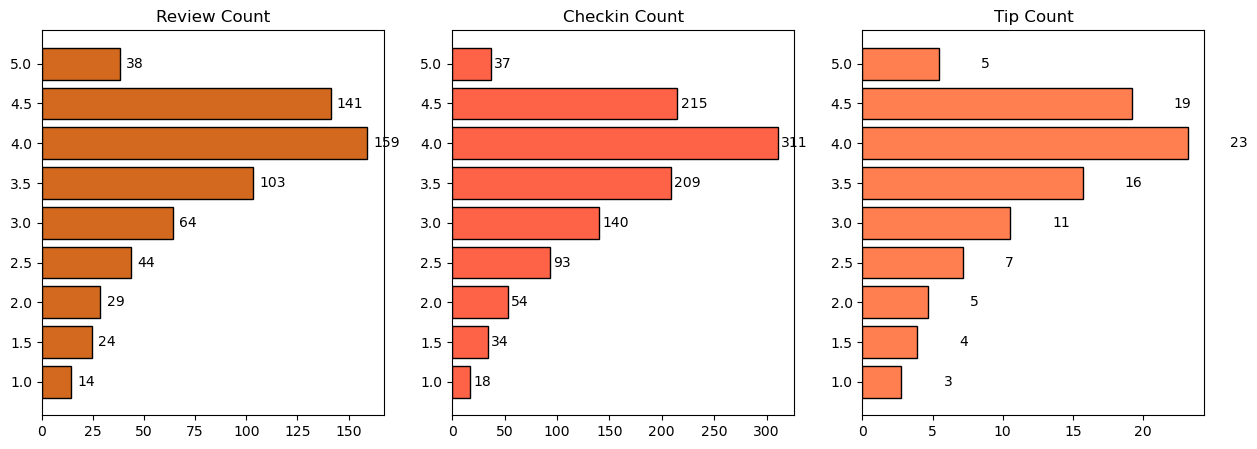

In [41]:
plt.figure(figsize=(15,5))
plt.title("Average Engagement Based on Rating")
plt.xticks([])
plt.yticks([])

plt.subplot(1,3,1)
plt.title("Review Count")
plt.barh(business_rating_analysis["Ratings"],business_rating_analysis["Average_review"],edgecolor="black",color="chocolate")
for i, value in enumerate(business_rating_analysis["Average_review"]):
    plt.text(value+3,i,str(round(value)),color='black',va="center")

plt.subplot(1,3,2)
plt.title("Checkin Count")
plt.barh(business_rating_analysis["Ratings"],business_rating_analysis["Average_checkin"],edgecolor="black",color="tomato")
for i, value in enumerate(business_rating_analysis["Average_checkin"]):
    plt.text(value+3,i,str(round(value)),color='black',va="center")
    
plt.subplot(1,3,3)
plt.title("Tip Count")
plt.barh(business_rating_analysis["Ratings"],business_rating_analysis["Average_tip"],edgecolor="black",color="coral")
for i, value in enumerate(business_rating_analysis["Average_tip"]):
    plt.text(value+3,i,str(round(value)),color='black',va="center")

plt.show()


**RESULT**: From the above visualization, we can say that:   

    1. the trend goes upwords till 4.0 Ratings
    2. the trend goes down after 4.0 Rating
    3. Similars Trends are been observed On Checkin and Tip Count AS well.
    
so, we can say that An idel Business is consider Successfull if it have rating : **4 - 4.5**  

Because as we see, after 4.5 Reviews counts are less, checkin count also become less, and tip count are also less. 

so business should focus on getting ratings upto **4 - 4.5**

### 5. Now, we will Analyse the correlation between the number of reviews, tips & checkins for a business

1. Total Engagement of Customer on the Basis of Business_id

In [23]:
query = """SELECT b.business_id,
           AVG(b.stars) as Average_Rating,
           SUM(b.review_count) as Total_Review,
           SUM(CHAR_LENGTH(c.date)-CHAR_LENGTH(REPLACE(c.date,',',''))+1) AS Total_checkin,
           SUM(t.tip_count) as Total_tip
           FROM business b
           LEFT JOIN Checkin c
           ON c.business_id = b.business_id
           LEFT JOIN (SELECT business_id,
                       COUNT(*) AS tip_count
                       FROM tip
                       GROUP BY business_id)
            t
            ON t.business_id = b.business_id
            WHERE categories like "%%restaurant%%" and is_open = 1
            GROUP BY business_id"""

business_id_analysis = pd.read_sql_query(query,con=engine).dropna()
business_id_analysis

,business_id,Average_Rating,Total_Review,Total_checkin,Total_tip
0,--0iUa4sNDFiZFrAdIWhZQ,3.0,14.0,10.0,6.0
1,CJoO4HYD0tZRXlZqA04wmw,4.5,435.0,1318.0,97.0
2,9n-1LQLX3ntBfBtMwgSpig,4.0,258.0,262.0,40.0
3,CVmzqrekI1iYHio8pTyTpA,4.0,466.0,1371.0,102.0
4,GzXA_ltTw34ViN5pSUkfoQ,3.5,313.0,569.0,24.0
...,...,...,...,...,...
34933,Fd4OmtDhowxzvYYIWA5Bcw,2.5,13.0,5.0,1.0
34938,dYMb9V0rUmspH-59KnobrA,1.5,23.0,6.0,1.0
34970,g5GS2Mr42rKXzFrzea5GJw,4.0,10.0,1.0,1.0
34973,r-776l-hZC4Vngbgn8KLQA,4.0,13.0,2.0,1.0


Checking, if any outliers present or not

In [24]:
def remove_outliers_2(df,col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    new_df = df[(df[col]>=lower)&(df[col]<=upper)]
    return new_df

In [25]:
aaa=remove_outliers_3(business_id_analysis,"Total_Review")

In [27]:
bbb=remove_outliers_3(business_id_analysis,"Total_checkin")

In [28]:
final_business_id_analysis = remove_outliers_3(business_id_analysis,"Total_tip")

In [29]:
business_id_analysis.shape

(31129, 5)

In [30]:
final_business_id_analysis.shape

(28133, 5)

2. Finding Corelation Between Business_id And (Total_review, Total checkin, Total tip) 

In [31]:
business_id_corelation = final_business_id_analysis[["Total_Review","Total_checkin","Total_tip"]].corr()
business_id_corelation

,Total_Review,Total_checkin,Total_tip
Total_Review,1.000000,0.687183,0.776033
Total_checkin,0.687183,1.000000,0.767199
Total_tip,0.776033,0.767199,1.000000


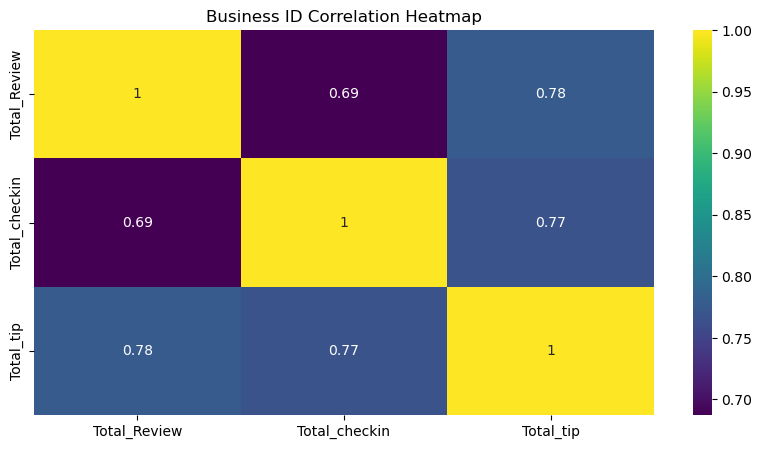

In [33]:
plt.figure(figsize=(10,5))

sns.heatmap(data=business_id_corelation,annot=True, cmap="viridis")
plt.title("Business ID Correlation Heatmap")
plt.show()

**RESULT** : From the above map, we can Analyze that:  

    1. If Reviews of Business Increases then automatically Checkin goes high as well as Tips count also Increase with high  level.   
    
Therefore Business Review, Business checkin, Business tips are highly corelated with each other.    

So, Restaurant should Target on Quality Work To obtain Good Reviews To INcrease Checkins in the Business.

### 6. Now, Analysing the User Engagement (Reviews, Checkins and tips) between High Rated and Low Rated Restaurant

Here, we gone Consider **Threshold value = 3.5** of **Ratings** which will define that,    

if Ratings is above 3.5 then its a high rated Restaurant   

if rating is lower than 3.5 then its a low rated Restaurant


1. Creating a Category Column on the Basis of Ratings which will define its a High rated and Low Rated Restaurant

In [37]:
query = """SELECT b.business_id,
           AVG(b.stars) as Average_Rating,
           SUM(b.review_count) as review_count,
           SUM(CHAR_LENGTH(c.date)-CHAR_LENGTH(REPLACE(c.date,',',''))+1) AS checkin_count,
           SUM(t.tip_count) as tip_count,
           (CASE WHEN AVG(b.stars) >= 3.5 Then "HIGH Rated" ELSE "LOW Rated" END) as Category
           FROM business b
           LEFT JOIN Checkin c
           ON c.business_id = b.business_id
           LEFT JOIN (SELECT business_id,
                       COUNT(*) AS tip_count
                       FROM tip
                       GROUP BY business_id)
            t
            ON t.business_id = b.business_id
            WHERE categories like "%%restaurant%%" and is_open = 1
            GROUP BY business_id"""

business_category = pd.read_sql_query(query,con=engine).dropna()
business_category

,business_id,Average_Rating,review_count,checkin_count,tip_count,Category
0,--0iUa4sNDFiZFrAdIWhZQ,3.0,14.0,10.0,6.0,LOW Rated
1,CJoO4HYD0tZRXlZqA04wmw,4.5,435.0,1318.0,97.0,HIGH Rated
2,9n-1LQLX3ntBfBtMwgSpig,4.0,258.0,262.0,40.0,HIGH Rated
3,CVmzqrekI1iYHio8pTyTpA,4.0,466.0,1371.0,102.0,HIGH Rated
4,GzXA_ltTw34ViN5pSUkfoQ,3.5,313.0,569.0,24.0,HIGH Rated
...,...,...,...,...,...,...
34933,Fd4OmtDhowxzvYYIWA5Bcw,2.5,13.0,5.0,1.0,LOW Rated
34938,dYMb9V0rUmspH-59KnobrA,1.5,23.0,6.0,1.0,LOW Rated
34970,g5GS2Mr42rKXzFrzea5GJw,4.0,10.0,1.0,1.0,HIGH Rated
34973,r-776l-hZC4Vngbgn8KLQA,4.0,13.0,2.0,1.0,HIGH Rated


Checking if any Outliers Present or not

In [38]:
def remove_outliers_3(df,col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    new_df = df[(df[col]>=lower)&(df[col]<=upper)]
    return new_df

In [39]:
aa=remove_outliers_3(business_category,"review_count")

In [40]:
bb=remove_outliers_3(business_category,"checkin_count")

In [41]:
final_business_category=remove_outliers_3(business_category,"tip_count")

In [42]:
business_category.shape

(31129, 6)

In [43]:
final_business_category.shape

(28133, 6)

In [44]:
avg_high_low_rate = final_business_category.groupby("Category")[["review_count","checkin_count","tip_count"]].mean()
avg_high_low_rate

,review_count,checkin_count,tip_count
Category,,,
HIGH Rated,82.387318,124.181415,10.023205
LOW Rated,43.760127,87.693319,6.383987


**RESULT** : This Indicates That The User/Customer Have Higher Engagement on High Rated Restaurant Rather Than Low Rated Restaurant.

## 7. Now we Will Analyze The Business Scucess, by calculating their Success Score

**Success Score** : A Success Score is a composite metric used to quantify how well a business is performing, based on multiple relevant factors.    
To Calculate a Sucess Score for each Business, You need to define what "Sucess" means in our Context.    

In Our Case Success Score based on TWO Metrics:
    1. Review
    2. Rating
    
    
So, Simply Our Approch Will Be **Weighted Sum Approach**:     

Here We, gonne Assign Weighted value (log Value) on review_count & multipy with Avg_rating.   

Success_Score = Average_rating * np.log(Total_review) 

In [4]:
import numpy as np

In [5]:
def calculate_success_score(df):
    success_score=[]
    
    for index,row in df.iterrows():
        score=row["Average_rating"] * np.log(row["Total_review"]+1)
        success_score.append(score)
    return success_score

Q1. How Do Success Metrics(review_count & avg_rating) of Restaurant vary across diffrent states and Cities?

In [6]:
query = """SELECT city, state,
           AVG(latitude) as Latitude,
           AVG(longitude) as Longitude,
           AVG(stars) as Average_rating,
           SUM(review_count) as Total_review,
           count(business_id) as Restaurant_count
           FROM business
           WHERE categories like "%%restaurant%%" and is_open = 1
           GROUP BY city, state
           ORDER BY Total_review DESC
           LIMIT 10"""

business_cities = pd.read_sql_query(query,con=engine)
business_cities



,city,state,Latitude,Longitude,Average_rating,Total_review,Restaurant_count
0,Philadelphia,PA,39.978451,-75.151865,3.585317,495523.0,3528
1,New Orleans,LA,29.958667,-90.075945,3.764537,387062.0,1393
2,Nashville,TN,36.143791,-86.771767,3.569222,261010.0,1683
3,Tampa,FL,27.999055,-82.477556,3.624049,236515.0,1971
4,Tucson,AZ,32.236753,-110.936069,3.458055,192708.0,1645
5,Indianapolis,IN,39.804451,-86.141169,3.482143,186614.0,1904
6,Reno,NV,39.506149,-119.805626,3.584375,151636.0,800
7,Santa Barbara,CA,34.423662,-119.710383,3.913677,127068.0,446
8,Saint Louis,MO,38.617332,-90.297616,3.502088,125866.0,958
9,Boise,ID,43.608677,-116.237632,3.597015,55551.0,603


Therefore, we will calculate the success score for each business based on our formula.

In [7]:
business_cities["success_score"] = calculate_success_score(business_cities)
business_cities

,city,state,Latitude,Longitude,Average_rating,Total_review,Restaurant_count,success_score
0,Philadelphia,PA,39.978451,-75.151865,3.585317,495523.0,3528,47.015598
1,New Orleans,LA,29.958667,-90.075945,3.764537,387062.0,1393,48.435823
2,Nashville,TN,36.143791,-86.771767,3.569222,261010.0,1683,44.516467
3,Tampa,FL,27.999055,-82.477556,3.624049,236515.0,1971,44.843149
4,Tucson,AZ,32.236753,-110.936069,3.458055,192708.0,1645,42.080848
5,Indianapolis,IN,39.804451,-86.141169,3.482143,186614.0,1904,42.262082
6,Reno,NV,39.506149,-119.805626,3.584375,151636.0,800,42.758887
7,Santa Barbara,CA,34.423662,-119.710383,3.913677,127068.0,446,45.995434
8,Saint Louis,MO,38.617332,-90.297616,3.502088,125866.0,958,41.124949
9,Boise,ID,43.608677,-116.237632,3.597015,55551.0,603,39.297657


**RESULT**: From the above table, We can Analyse that:  
        
1. Philadelphia emerges as the top city with the highest success score,
indicating a combination of high ratings and active user engagement.

2. Following Philad elphia, New O rleans, Nashville , and Tampa rank among the
top cities with significant success scores, suggesting thriving restaurant
scenes in these areas.

Creating a base map by using folium library



In [8]:
pip install folium

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [9]:
import folium


m = folium.Map(location=[business_cities["Latitude"].mean(),business_cities["Longitude"].mean()],zoom_start=4)

color_scale = folium.LinearColormap(colors=["green","yellow","Red"], vmin=business_cities["success_score"].min(),
                                   vmax=business_cities["success_score"].max())

for index, row in business_cities.iterrows():
    folium.CircleMarker(location=[row["Latitude"],row["Longitude"]], radius=5,
                       color=color_scale(row["success_score"]), fill=True,
                       fill_color=color_scale(row["success_score"]),fill_opacity=0.7).add_to(m)
    
m.add_child(color_scale)

## 8. NOW,  Time Trend Analysis of Ratings, Review on the basis of DATE & TIME 

Q1. Are There Any Trends or Pattern in User Engagement  Over Time for Succesfull Business Compared to Less Sucessful Ones?

Q2. Are There Any Seasonal Trends in User Engagement for Restaurant?

Therefore, According to Our Analysis Lets Calculate Review_count, Tip_count for Higher & Lower Engagement According To month_year

1. for Higher Engagement

In [42]:
query = """SELECT r.month_year, r.review_count, t.tip_count
           FROM 
           (SELECT DATE_FORMAT(r.date,"%%m-%%y") as month_year,
                   COUNT(*) as review_count
            FROM review r
            JOIN business b
            ON r.business_id = b.business_id
            WHERE b.categories LIKE "%%restaurant%%" AND b.is_open = 1 AND b.stars >= 3.5
            GROUP BY month_year) as r
            JOIN 
            (SELECT DATE_FORMAT(t.date,"%%m-%%y") as month_year,
                    COUNT(*) as tip_count
             FROM tip t
             JOIN business b
             ON t.business_id = b.business_id
             WHERE b.categories LIKE "%%restaurant%%" AND b.is_open = 1 AND b.stars >= 3.5
             GROUP BY month_year) as t
            ON r.month_year = t.month_year
            ORDER BY r.month_year"""

high_rated_engagement = pd.read_sql_query(query,con=engine)
high_rated_engagement

,month_year,review_count,tip_count
0,01-10,4183,218
1,01-11,6896,1678
2,01-12,9680,3415
3,01-13,11634,2925
4,01-14,15836,3279
...,...,...,...
149,12-17,29384,3204
150,12-18,34713,2535
151,12-19,33321,2131
152,12-20,22502,1543


2. for Lower Engagement

In [43]:
query = """SELECT r.month_year,r.review_count,t.tip_count
           FROM
           (SELECT DATE_FORMAT(r.date,"%%m-%%y") as month_year,
                   COUNT(*) as review_count
            FROM review r
            JOIN business b
            ON r.business_id = b.business_id
            WHERE b.categories LIKE "%%restaurant%%" AND b.is_open = 1 AND b.stars <3.5
            GROUP BY month_year) as r
           JOIN
           (SELECT DATE_FORMAT(t.date,"%%m-%%y") as month_year,
                   COUNT(*) as tip_count
            FROM tip t
            JOIN business b
            ON t.business_id = b.business_id
            WHERE b.categories LIKE "%%restaurant%%" AND b.is_open = 1 AND b.stars <3.5
            GROUP BY month_year) as t
           ON r.month_year = t.month_year
           ORDER BY r.month_year"""

low_rated_engagement = pd.read_sql_query(query,con=engine)
low_rated_engagement

,month_year,review_count,tip_count
0,01-10,706,34
1,01-11,1186,403
2,01-12,1704,694
3,01-13,2169,661
4,01-14,2676,726
...,...,...,...
149,12-17,5103,502
150,12-18,6094,392
151,12-19,5707,325
152,12-20,3577,168


NOW, Calculating the Average Review for every month-year

In [64]:
query = """SELECT DATE_FORMAT(r.date,"%%m-%%y") as month_year,
        AVG(b.stars) as average_rating
        FROM review r
        JOIN business b
        ON r.business_id = b.business_id
        WHERE b.categories LIKE "%%restaurant%%" AND b.is_open = 1
        GROUP BY month_year
        ORDER BY month_year"""

month_year_rating = pd.read_sql_query(query,con=engine)
month_year_rating

,month_year,average_rating
0,01-06,3.679775
1,01-07,3.685393
2,01-08,3.753755
3,01-09,3.717552
4,01-10,3.762017
...,...,...
199,12-17,3.823484
200,12-18,3.836180
201,12-19,3.856347
202,12-20,3.899900


AS, We Can See No need of Old Data for Analysis because its too OLD.     

so we gonna Consider The Data From **2018** for Analysis Purpose. Because Latest Data Can give us Latest Trends & Insights.

In [73]:
high_rated_engagement["month_year"] = pd.to_datetime(high_rated_engagement["month_year"], format="%m-%y")
high_rated_engagement.sort_values("month_year",inplace=True)
high_rated_engagement = high_rated_engagement[high_rated_engagement["month_year"]> pd.to_datetime("2017", format="%Y")]

low_rated_engagement["month_year"] = pd.to_datetime(low_rated_engagement["month_year"], format="%m-%y")
low_rated_engagement.sort_values("month_year",inplace=True)
low_rated_engagement = low_rated_engagement[low_rated_engagement["month_year"]> pd.to_datetime("2017", format="%Y")]

month_year_rating["month_year"] = pd.to_datetime(month_year_rating["month_year"], format="%m-%y")
month_year_rating.sort_values("month_year",inplace=True)
month_year_rating = month_year_rating[month_year_rating["month_year"]> pd.to_datetime("2017", format="%Y")]

In [95]:
high_rated_engagement.shape


((60, 4),)

In [75]:
low_rated_engagement.shape

(60, 3)

In [76]:
month_year_rating.shape

(60, 2)

We gonna take High Rated engagement for analysis, because user engagements are more on High rated Restaurants(based on above analysis)

In [77]:
high_rated_engagement["average_rating"] = month_year_rating["average_rating"].values

In [78]:
high_rated_engagement.head()

,month_year,review_count,tip_count,average_rating
20,2017-02-01,28110,3572,3.828518
32,2017-03-01,32236,4640,3.830891
45,2017-04-01,32089,4634,3.829680
58,2017-05-01,33802,4293,3.830867
71,2017-06-01,33957,4232,3.838044


[]

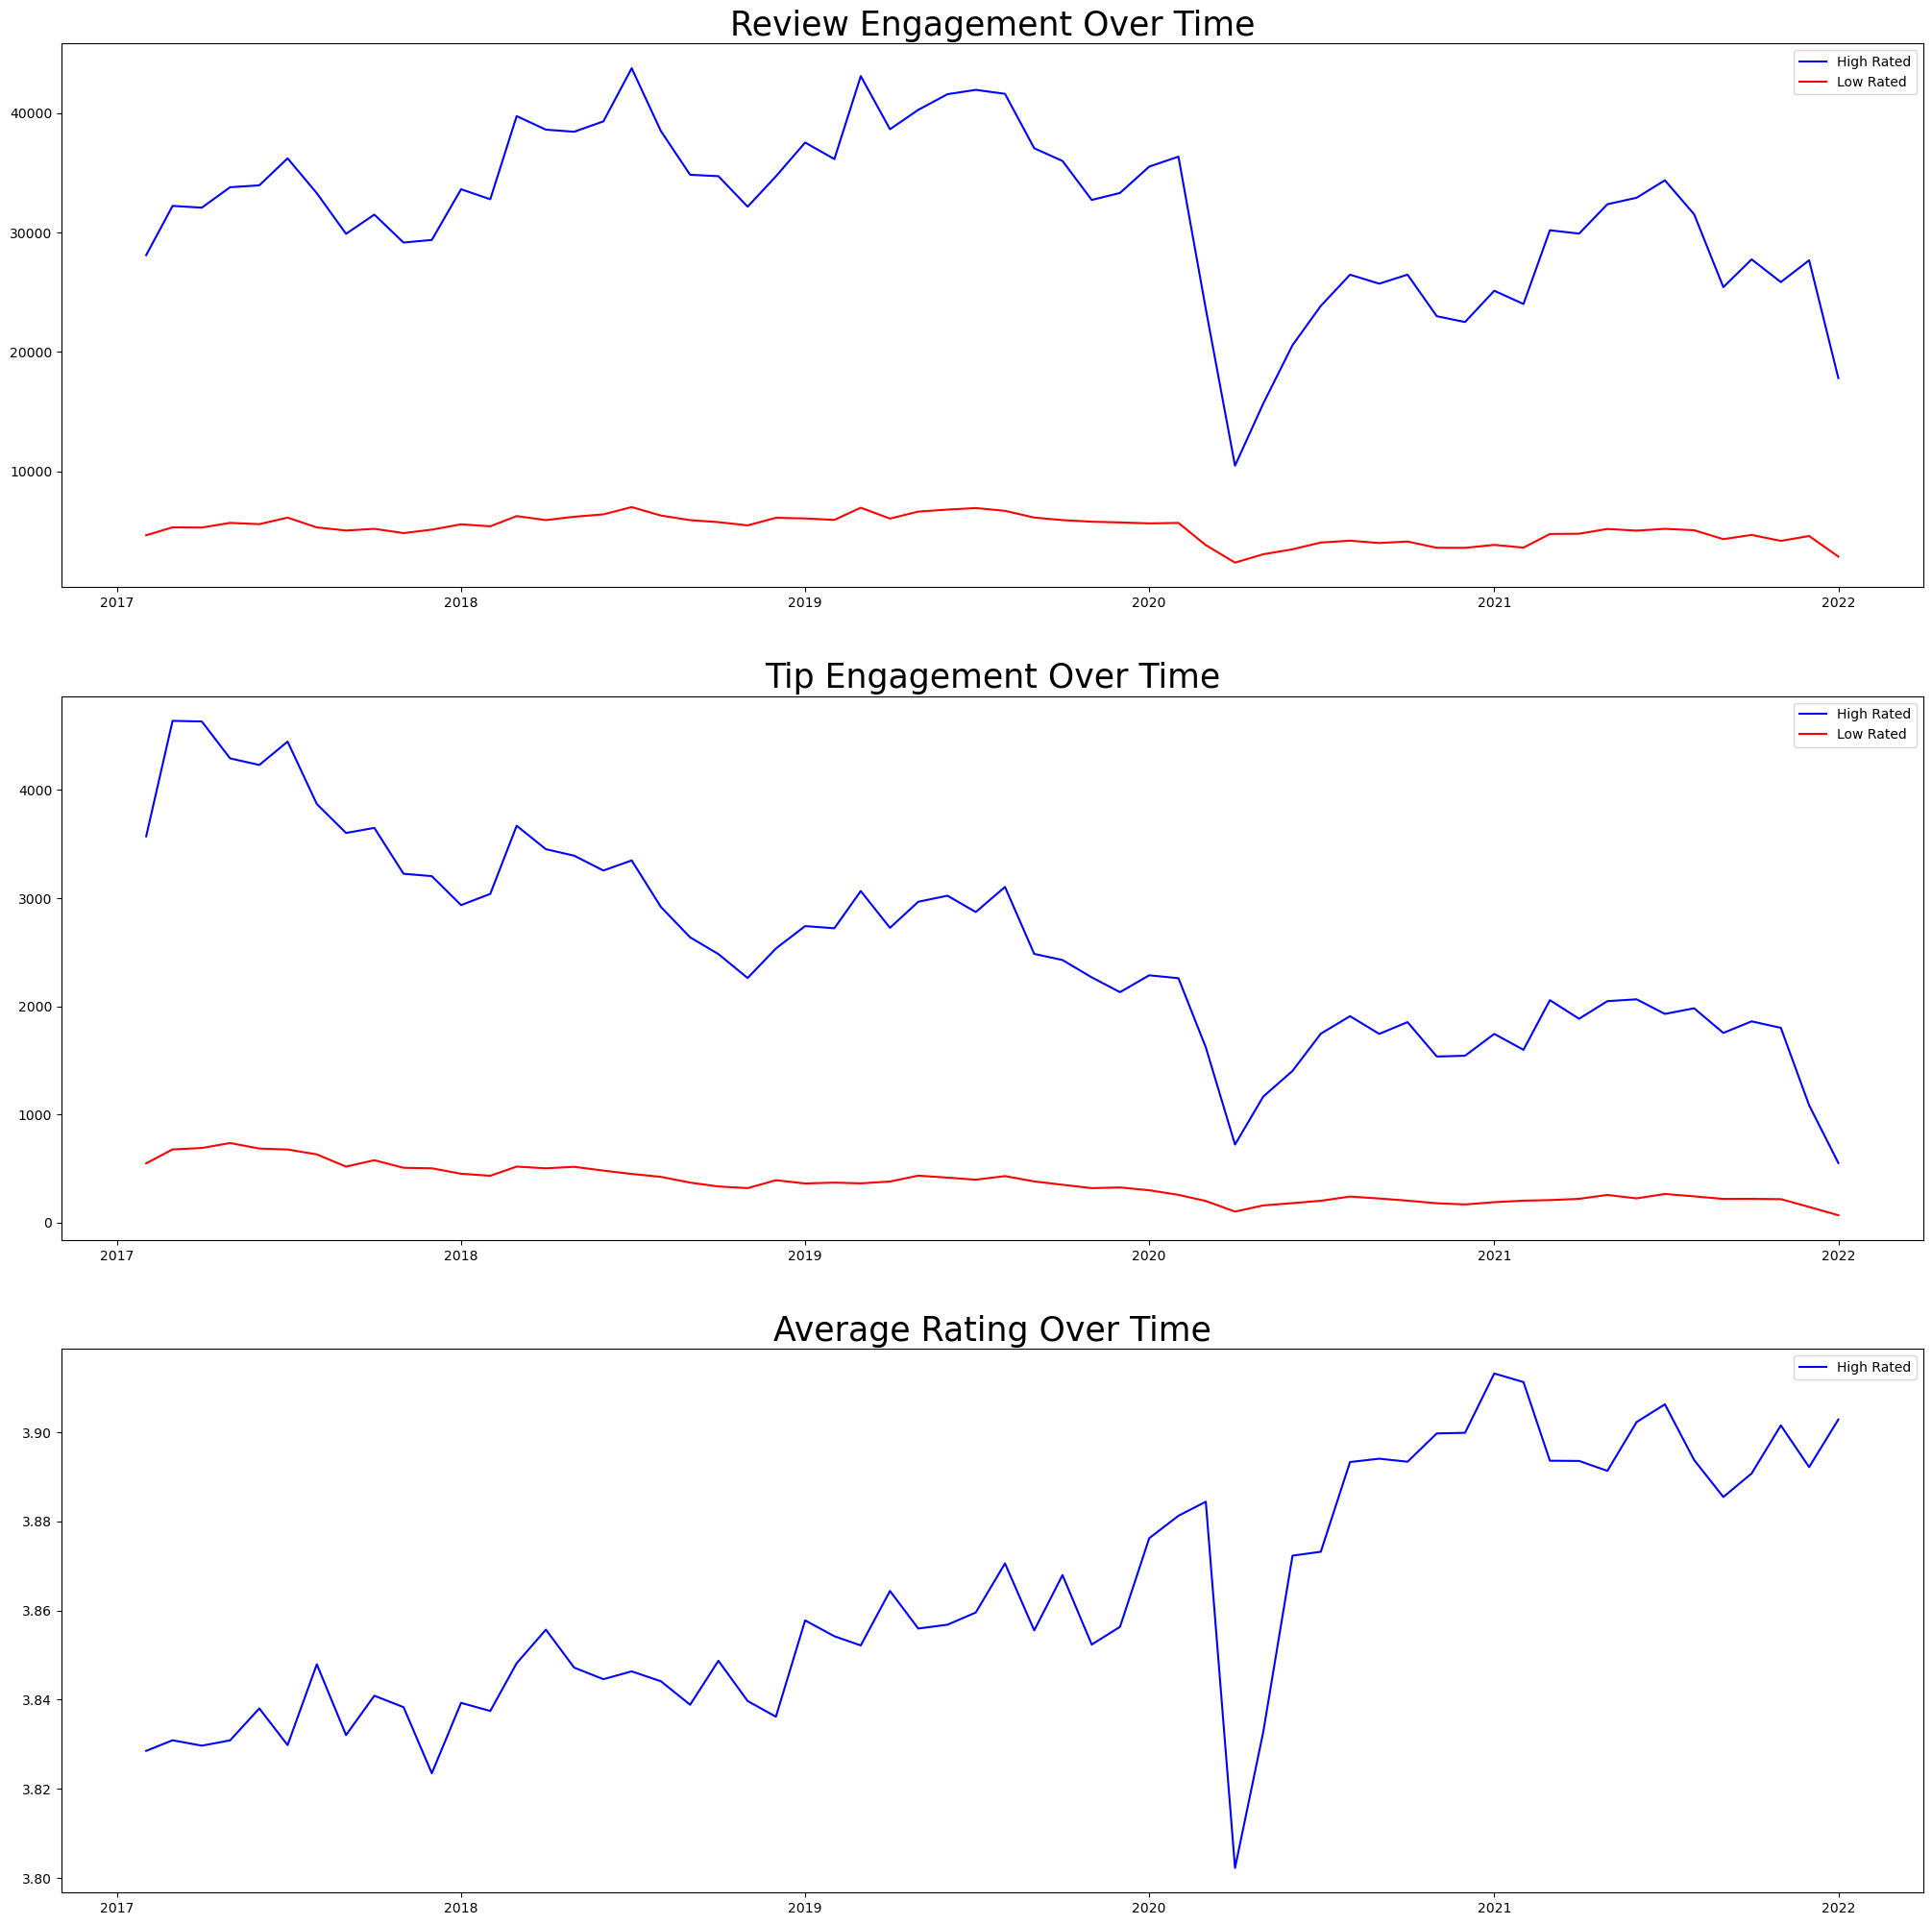

In [90]:
plt.figure(figsize=(25,25))

plt.subplot(3,1,1)
plt.title("Review Engagement Over Time",fontsize=25)
plt.plot(high_rated_engagement["month_year"],high_rated_engagement["review_count"],label="High Rated",color="Blue")
plt.plot(low_rated_engagement["month_year"],low_rated_engagement["review_count"],label="Low Rated",color="red")
plt.legend()

plt.subplot(3,1,2)
plt.title("Tip Engagement Over Time",fontsize=25)
plt.plot(high_rated_engagement["month_year"],high_rated_engagement["tip_count"],label="High Rated",color="Blue")
plt.plot(low_rated_engagement["month_year"],low_rated_engagement["tip_count"],label="Low Rated",color="red")
plt.legend()

plt.subplot(3,1,3)
plt.title("Average Rating Over Time",fontsize=25)
plt.plot(high_rated_engagement["month_year"],high_rated_engagement["average_rating"],label="High Rated",color="Blue")
plt.legend()


plt.plot()


**RESULT** : As we can Analyse from the above Graph:   

        1. There is a huge drop near 2020 on High rated user Engagement. May be, because of COVID-19.
        2. Tip count trend is decreasing with the month_year, where as Review count trend is increasing month_year.
        3. Huge upward Trend in Avg Ratings after 2020.

For Better Understanding of Seasonal Trends, we have a function called seasonal_decompose.     

by using seasonal_decompose we can finds seasonal trends based on period given.

so, we will analyse on high rated engagement

In [93]:
review_high_rated = high_rated_engagement[["month_year","review_count"]].set_index("month_year")

tip_high_rated = high_rated_engagement[["month_year","tip_count"]].set_index("month_year")

avg_rating = month_year_rating[["month_year","average_rating"]].set_index("month_year")

**1. for review_count**

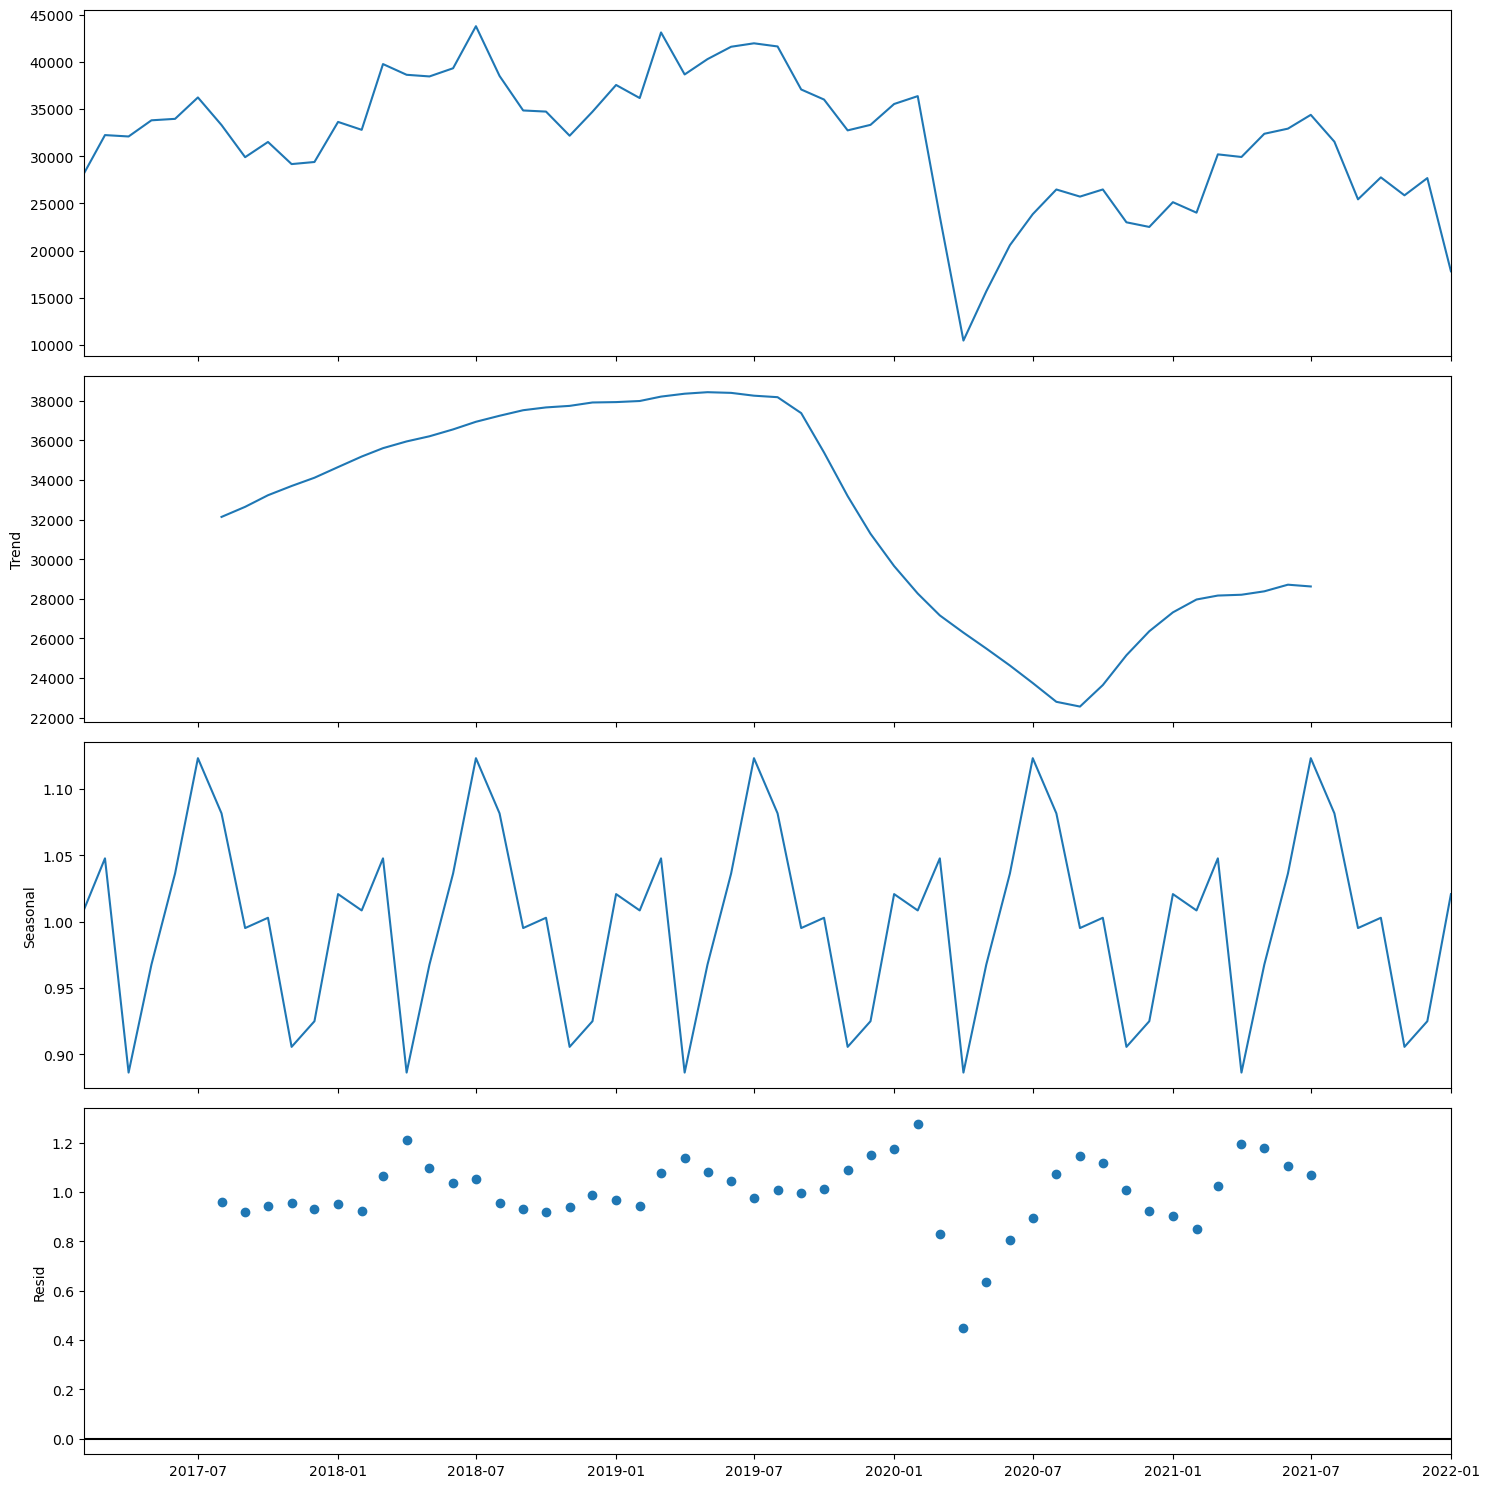

In [92]:
from statsmodels.tsa.seasonal import seasonal_decompose
multiplicative_decomposition = seasonal_decompose(review_high_rated,model="multiplicative",period=12)

plt.rcParams.update({'figure.figsize':(15,15)})
multiplicative_decomposition.plot()
plt.show()

**2. for tip_count**

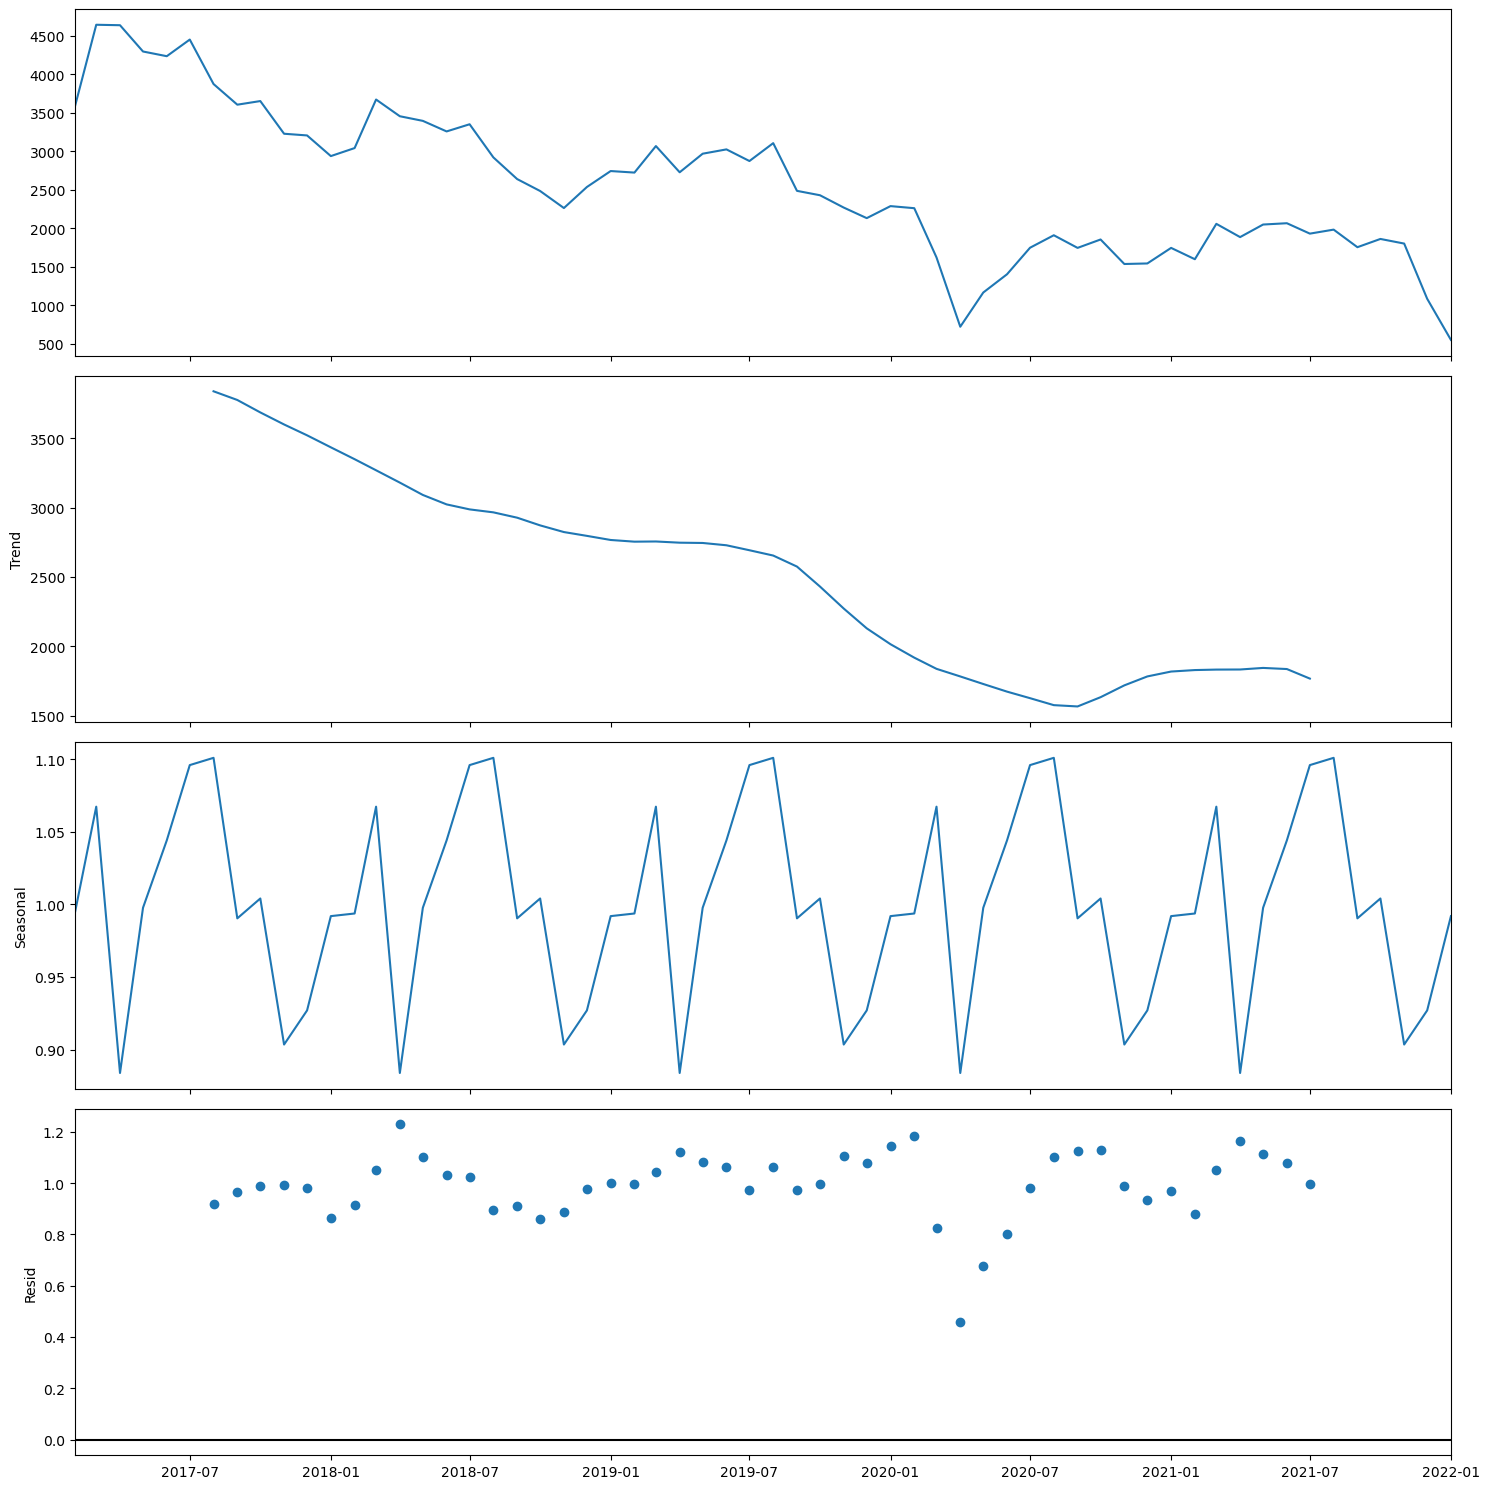

In [86]:
from statsmodels.tsa.seasonal import seasonal_decompose
multiplicative_decomposition = seasonal_decompose(tip_high_rated,model="multiplicative",period=12)

plt.rcParams.update({'figure.figsize':(15,15)})
multiplicative_decomposition.plot()
plt.show()

**3. for average_rating**

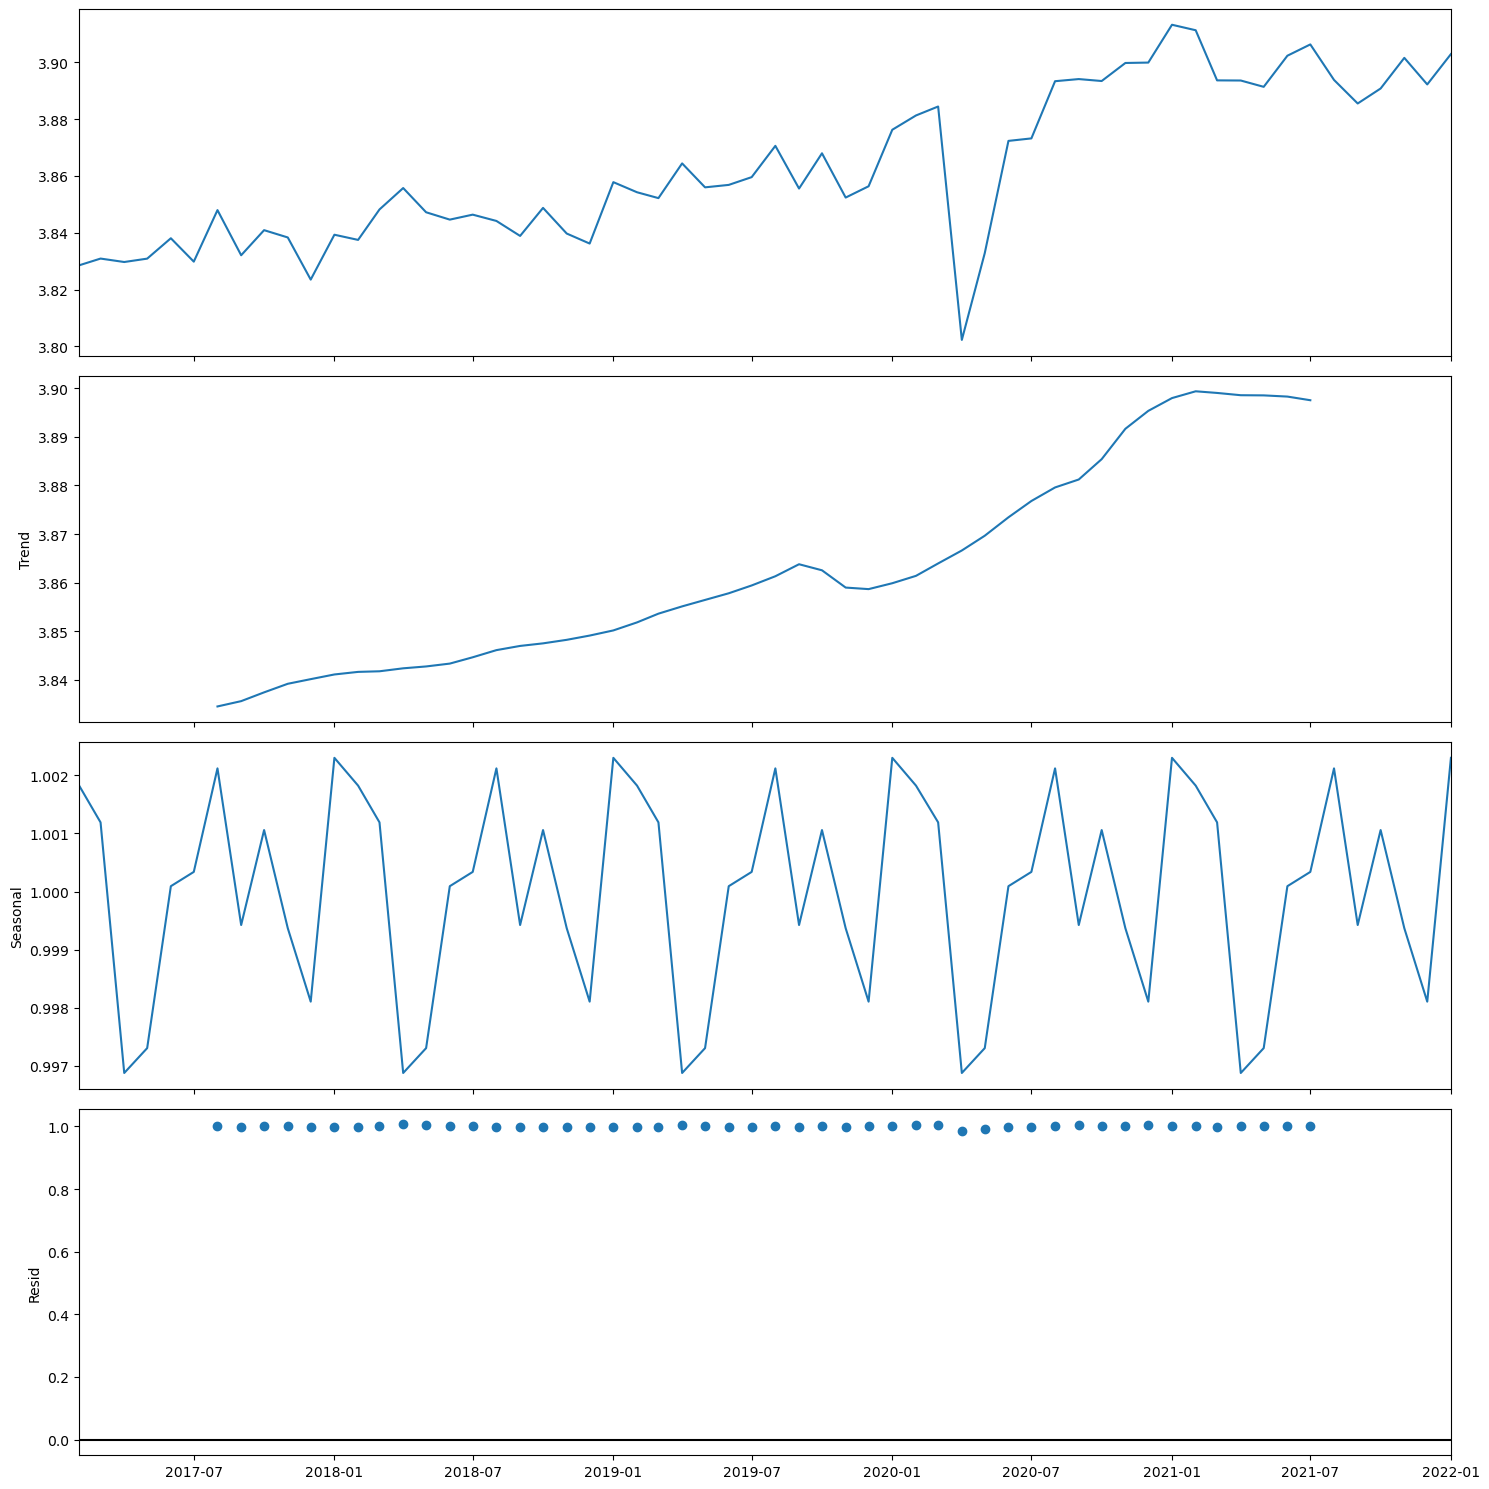

In [94]:
from statsmodels.tsa.seasonal import seasonal_decompose
multiplicative_decomposition = seasonal_decompose(avg_rating,model="multiplicative",period=12)

plt.rcParams.update({'figure.figsize':(15,15)})
multiplicative_decomposition.plot()
plt.show()

## 9. Now, Analysis on Sentimental Reviews (useful,funny,cool)

Q1. How does the sentiment of Reviews and Tips(useful,funny,cool) corelate with the success metrics of restaurants?

In [50]:
query = """SELECT b.business_id, AVG(b.stars) as average_rating, SUM(b.review_count) as review_count,
           r.useful_count as useful_count,
           r.funny_count as funny_count,
           r.cool_count as cool_count
           FROM
           (SELECT business_id,
                   SUM(useful) as useful_count,
                   SUM(funny) as funny_count,
                   SUM(cool) as cool_count
            FROM review
            GROUP BY business_id) as r
           JOIN business b
           ON r.business_id = b.business_id
           WHERE b.categories LIKE "%%restaurant%%" AND b.is_open = 1
           GROUP BY business_id
           ORDER BY review_count"""

sentiment_analysis = pd.read_sql_query(query,con=engine)
sentiment_analysis

,business_id,average_rating,review_count,useful_count,funny_count,cool_count
0,cf8I3oeXh51qGM2L9pWutg,2.0,5.0,1.0,0.0,0.0
1,5M3AWxHBAJn6ET3AtBzmDw,4.0,5.0,3.0,1.0,1.0
2,An0Y9T29wX3QS7iSs1qteQ,4.0,5.0,1.0,1.0,2.0
3,n0CdVw9AEmVRAIy7i1F6ag,4.0,5.0,11.0,1.0,6.0
4,k_mIcCFvXWuN8I4ofCta3g,1.0,5.0,5.0,2.0,2.0
...,...,...,...,...,...,...
34999,oBNrLz4EDhiscSlbOl8uAw,4.5,5193.0,2189.0,705.0,1386.0
35000,ytynqOUb3hjKeJfRj5Tshw,4.5,5721.0,4923.0,2061.0,3625.0
35001,GXFMD0Z4jEVZBCsbPf4CTQ,4.5,6093.0,3756.0,1831.0,2845.0
35002,ac1AeYqs8Z4_e2X5M3if2A,4.0,7400.0,3692.0,1206.0,1906.0


REmoving Outliers from Data, before Finding correlations

In [51]:
def remove_outliers_4(df,col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    new_df = df[(df[col]>=lower)&(df[col]<=upper)]
    return new_df

In [56]:
a=remove_outliers_4(sentiment_analysis,"review_count")


In [57]:
b=remove_outliers_4(sentiment_analysis,"useful_count")
c=remove_outliers_4(sentiment_analysis,"funny_count")

In [58]:
final_sentimental_analysis =remove_outliers_2(sentiment_analysis,"cool_count")
final_sentimental_analysis

,business_id,average_rating,review_count,useful_count,funny_count,cool_count
0,cf8I3oeXh51qGM2L9pWutg,2.0,5.0,1.0,0.0,0.0
1,5M3AWxHBAJn6ET3AtBzmDw,4.0,5.0,3.0,1.0,1.0
2,An0Y9T29wX3QS7iSs1qteQ,4.0,5.0,1.0,1.0,2.0
3,n0CdVw9AEmVRAIy7i1F6ag,4.0,5.0,11.0,1.0,6.0
4,k_mIcCFvXWuN8I4ofCta3g,1.0,5.0,5.0,2.0,2.0
...,...,...,...,...,...,...
34322,KU7XnbHB-EBOCbyXH0VVuQ,4.0,644.0,271.0,60.0,120.0
34340,dpqDfbNpcIERkXVoE5S9Wg,2.5,651.0,495.0,116.0,101.0
34341,5Jta7dTc7lteIyeMfLUJWQ,2.5,651.0,334.0,100.0,99.0
34366,L-YdO_NODKXXT3bkS0nUpg,3.5,664.0,347.0,55.0,112.0


Calculating the Success Score, by using the Same Formula

In [59]:
def calculate_success_score_2(df):
    success_score=[]
    
    for index,row in df.iterrows():
        score=row["average_rating"] * np.log(row["review_count"]+1)
        success_score.append(score)
    return success_score

In [60]:
final_sentimental_analysis["success_score"] = calculate_success_score_2(final_sentimental_analysis)

In [61]:
final_sentimental_analysis

,business_id,average_rating,review_count,useful_count,funny_count,cool_count,success_score
0,cf8I3oeXh51qGM2L9pWutg,2.0,5.0,1.0,0.0,0.0,3.583519
1,5M3AWxHBAJn6ET3AtBzmDw,4.0,5.0,3.0,1.0,1.0,7.167038
2,An0Y9T29wX3QS7iSs1qteQ,4.0,5.0,1.0,1.0,2.0,7.167038
3,n0CdVw9AEmVRAIy7i1F6ag,4.0,5.0,11.0,1.0,6.0,7.167038
4,k_mIcCFvXWuN8I4ofCta3g,1.0,5.0,5.0,2.0,2.0,1.791759
...,...,...,...,...,...,...,...
34322,KU7XnbHB-EBOCbyXH0VVuQ,4.0,644.0,271.0,60.0,120.0,25.877001
34340,dpqDfbNpcIERkXVoE5S9Wg,2.5,651.0,495.0,116.0,101.0,16.200111
34341,5Jta7dTc7lteIyeMfLUJWQ,2.5,651.0,334.0,100.0,99.0,16.200111
34366,L-YdO_NODKXXT3bkS0nUpg,3.5,664.0,347.0,55.0,112.0,22.749255


Finding Corelations between Sentimental Analysis

In [62]:
final_sentimental_analysis.iloc[:,2:].corr()

,review_count,useful_count,funny_count,cool_count,success_score
review_count,1.000000,0.822076,0.725705,0.767292,0.727944
useful_count,0.822076,1.000000,0.827509,0.840501,0.660788
funny_count,0.725705,0.827509,1.000000,0.798260,0.543164
cool_count,0.767292,0.840501,0.798260,1.000000,0.725267
success_score,0.727944,0.660788,0.543164,0.725267,1.000000


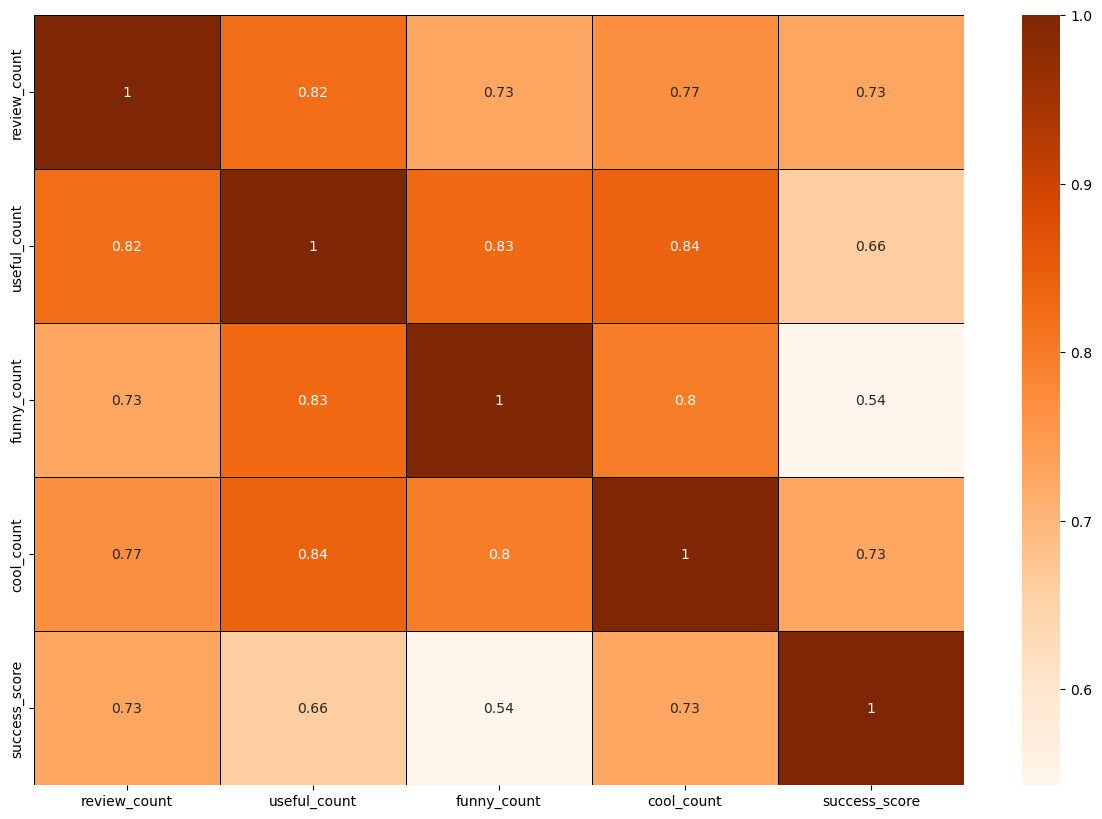

In [63]:
plt.figure(figsize=(15,10))
sns.heatmap(final_sentimental_analysis.iloc[:,2:].corr(),annot=True,cmap= "Oranges",linecolor="black",linewidth=0.5)
plt.show()

**RESULT**: from the above heatmap, we can analyze following points.
1. Success score is highly corelated with usefull_count & Cool_Count.
2. a very little corelation with funny_count but very less as compared to usefull_count & cool_count.

so, we can say that if a review found is usefull or cool then that business score may increse.

## 10. Now, Analysis on Elite Users & Regular Users

Q. Is There any diffrence in engagement of elite users and non elite users

In [138]:
query = """SELECT u.user_elite,
           COUNT(*) as user_count,
           SUM(u.review_count) as total_review_count
           FROM
           (SELECT 
            CASE when elite = '' then "NON Elite User" ELSE "Elite user" END as "user_elite",
            review_count
            FROM user) AS u
           GROUP BY u.user_elite"""

elite_user_analysis = pd.read_sql_query(query,con=engine)
elite_user_analysis

,user_elite,user_count,total_review_count
0,Elite user,91198,20484441.0
1,NON Elite User,1896699,26021235.0


Therefore, Elite users are less in numbers but they gives more reviews.

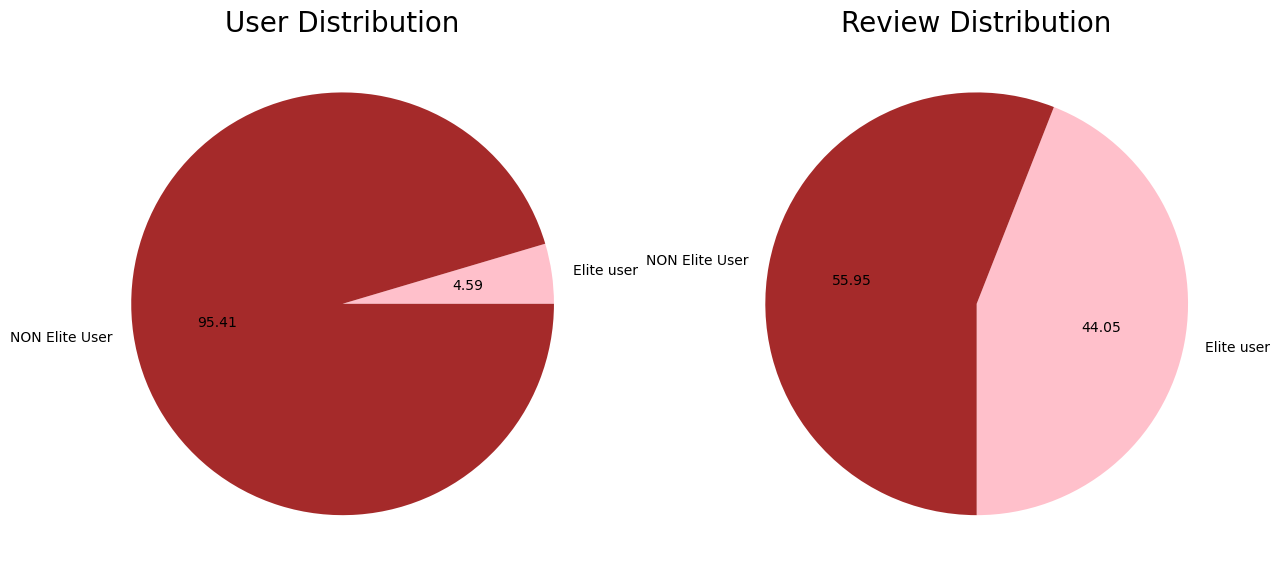

In [159]:
plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.title("User Distribution",fontsize=20)
plt.pie(elite_user_analysis["user_count"],labels=elite_user_analysis["user_elite"],autopct="%.2f",colors=["pink","brown",],
       startangle=360)

plt.subplot(1,2,2)
plt.title("Review Distribution",fontsize=20)
plt.pie(elite_user_analysis["total_review_count"],labels=elite_user_analysis["user_elite"],autopct="%.2f",
        colors=["pink","brown"],startangle=270)

plt.show()

**RESULT** : Elite Users are less in numbers but they gave More reviews over the yelp platform. So, ELITE Users helps to get good Business Score & for the Business success.    
So, Businesses Should Collabrate with Elite Users to improve Business success.

## 11. NOW, Analysis of user engagement on Business hours

Q1. What are the busiestvhours for restaurants?

In [185]:
query = """SELECT 
           DATE_FORMAT(date,"%%H") as hour,
           COUNT(*) as review_count
           FROM review
           GROUP BY hour"""

review_engagement = pd.read_sql_query(query,con=engine)
review_engagement

,hour,review_count
0,22,435185
1,15,357945
2,20,452524
3,00,460765
4,23,448405
5,02,416472
6,07,60031
7,14,299955
8,19,463727
9,17,441397


In [186]:
review_engagement['hour'] = review_engagement['hour'].astype(int)

In [187]:
query = """SELECT
           DATE_FORMAT(date,"%%H") as hour,
           COUNT(*) as tip_count
           FROM tip
           GROUP BY hour"""

tip_engagement = pd.read_sql_query(query,con=engine)
tip_engagement

,hour,tip_count
0,02,54532
1,18,63585
2,00,74238
3,23,73222
4,19,60871
5,04,27227
6,22,65779
7,01,67568
8,21,58630
9,17,62076


In [188]:
tip_engagement['hour'] = tip_engagement['hour'].astype(int)

In [162]:
query = """SELECT date FROM checkin"""

checkin = pd.read_sql_query(query,con=engine)
checkin

,date
0,"2020-03-13 21:10:56, 2020-06-02 22:18:06, 2020..."
1,"2010-09-13 21:43:09, 2011-05-04 23:08:15, 2011..."
2,"2013-06-14 23:29:17, 2014-08-13 23:20:22"
3,"2011-02-15 17:12:00, 2011-07-28 02:46:10, 2012..."
4,"2014-04-21 20:42:11, 2014-04-28 21:04:46, 2014..."
...,...
131925,"2013-03-23 16:22:47, 2013-04-07 02:03:12, 2013..."
131926,2021-06-12 01:16:12
131927,"2011-05-24 01:35:13, 2012-01-01 23:44:33, 2012..."
131928,"2016-12-03 23:33:26, 2018-12-02 19:08:45"


In [164]:
from datetime import datetime

checkin_engagement = []
for i in checkin["date"]:
    checkin_engagement.extend([datetime.strptime(j.strip(),"%Y-%m-%d %H:%M:%S").strftime("%H") for j in i.split(',')])
    
checkin_engagement = pd.DataFrame(checkin_engagement).astype("int").groupby(0)[[0]].count()

In [171]:
checkin_engagement.rename(columns={"0":["checkin_count"]},inplace=True)
checkin_engagement

,0
0,
0,1155092
1,935985
2,669574
3,437035
4,264905
5,152476
6,85066
7,52295
8,35589


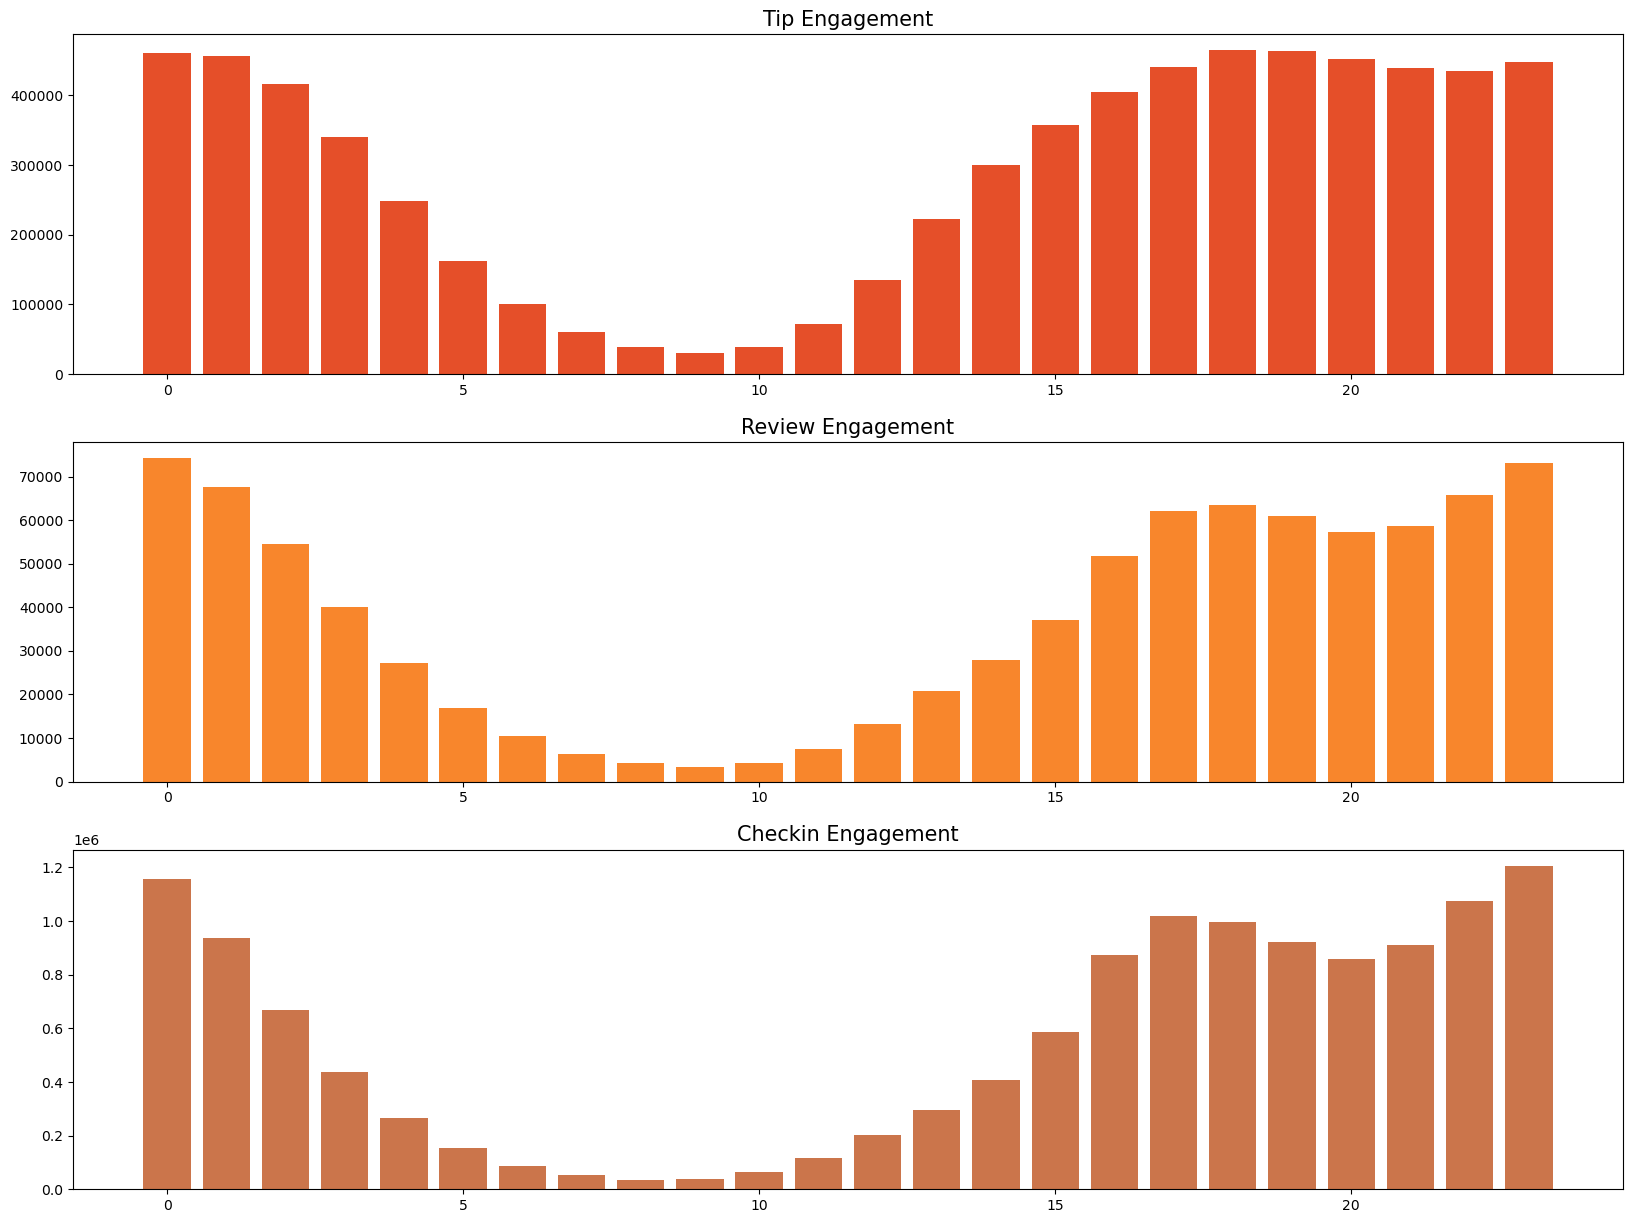

In [189]:
plt.figure(figsize = (20,15))

plt.subplot(3,1,1)
plt.title("Tip Engagement",fontsize=15)
plt.bar(review_engagement["hour"],review_engagement["review_count"],color = "#E54F29")

plt.subplot(3,1,2)
plt.title("Review Engagement",fontsize=15)
plt.bar(tip_engagement["hour"],tip_engagement["tip_count"],color = "#F8862C")

plt.subplot(3,1,3)
plt.title("Checkin Engagement",fontsize=15)
plt.bar(checkin_engagement.index,checkin_engagement[0],color="#CB754B")

plt.show()

**RESULT** : from the above bar graph we can analyse that:   
        
1. User Engagement High after 4pm and increases with the time upto 1pm.
2. User engagement is very low in morning to afternoon. 